In [2073]:
import pandas as pd
import numpy as np
import re
import seaborn as snsb
import matplotlib.pyplot as plt

In [2074]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, \
                            auc, confusion_matrix, classification_report, fbeta_score
from sklearn.preprocessing import StandardScaler

In [2075]:
books = pd.read_pickle('clean_data.pkl')
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42340 entries, 0 to 44366
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               42340 non-null  object 
 1   author              42340 non-null  object 
 2   rating_count        42340 non-null  int64  
 3   review_count        42340 non-null  int64  
 4   average_rating      42340 non-null  float64
 5   five_star_ratings   42340 non-null  int64  
 6   four_star_ratings   42340 non-null  int64  
 7   three_star_ratings  42340 non-null  int64  
 8   two_star_ratings    42340 non-null  int64  
 9   one_star_ratings    42340 non-null  int64  
 10  number_of_pages     42340 non-null  float64
 11  publisher           42340 non-null  object 
 12  genre_and_votes     42340 non-null  object 
 13  description         42340 non-null  object 
 14  is_series           42340 non-null  int64  
 15  has_won_award       42340 non-null  int64  
 16  nyt_

# Baseline

In [2085]:
#create baseline dataframe with only numeric and non-engineered features
base = books.select_dtypes('number').drop(columns=['rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings', 'three_star_ratings',
                           'two_star_ratings', 'one_star_ratings', 'is_series', 'has_won_award'])
pd.to_pickle( base, 'base_df.pkl')

In [2086]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42340 entries, 0 to 44366
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   average_rating   42340 non-null  float64
 1   number_of_pages  42340 non-null  float64
 2   nyt_best_seller  42340 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.3 MB


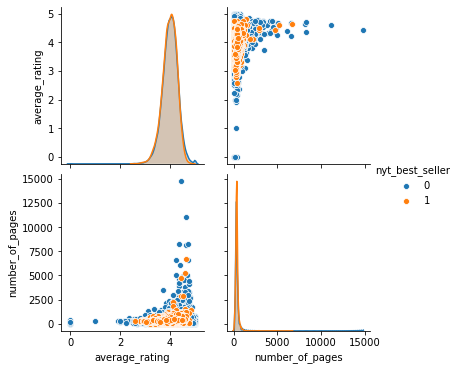

In [2087]:
sns.pairplot(base, hue='nyt_best_seller')

In [2088]:
X = base.drop(columns = ['nyt_best_seller'], axis = 1)
y = base['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2089]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2090]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2091]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

# Model 0

In [2092]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.914 +- 0.001
KNeighborsClassifier: 0.609 +- 0.007
LogisticRegression: 0.789 +- 0.018
GaussianNB: 0.752 +- 0.077
BernoulliNB: 0.914 +- 0.003
SVC: 0.686 +- 0.013
DecisionTreeClassifier: 0.593 +- 0.006
RandomForestClassifier: 0.597 +- 0.002

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.111 +- 0.005
LogisticRegression: 0.110 +- 0.006
GaussianNB: 0.111 +- 0.011
BernoulliNB: 0.000 +- 0.000
SVC: 0.125 +- 0.005
DecisionTreeClassifier: 0.099 +- 0.005
RandomForestClassifier: 0.106 +- 0.001

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.503 +- 0.018
LogisticRegression: 0.206 +- 0.033
GaussianNB: 0.283 +- 0.159
BernoulliNB: 0.000 +- 0.000
SVC: 0.441 +- 0.036
DecisionTreeClassifier: 0.457 +- 0.015
RandomForestClassifier: 0.495 +- 0.019

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.182 +- 0.007
LogisticRegression: 0.143 +- 0.010
Gauss

In [2094]:
model.feature_importances_

array([0.43431798, 0.56568202])

DummyClassifier AUC: 0.500
KNeighborsClassifier AUC: 0.569
LogisticRegression AUC: 0.594
GaussianNB AUC: 0.588
BernoulliNB AUC: 0.502
SVC AUC: 0.610
DecisionTreeClassifier AUC: 0.535
RandomForestClassifier AUC: 0.569


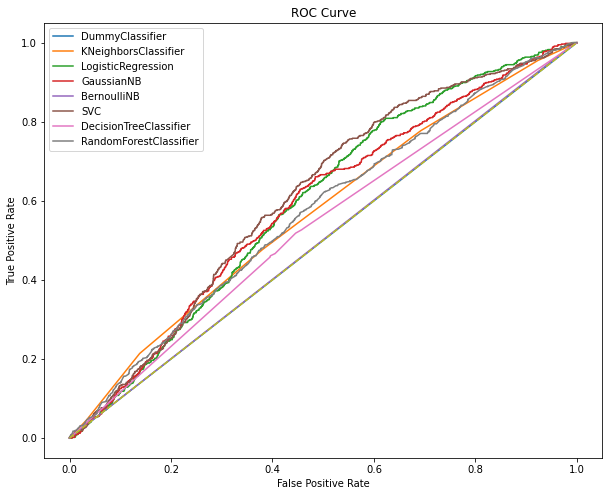

In [2095]:
plt.figure(figsize=(10,8))

model_rates = []
for model in models:
    name = str(model).split('(')[0]
    ml = model
    ml.fit(X_tr_rs, y_tr_rs)
    
    fpr, tpr, thresholds = roc_curve(y_val, ml.predict_proba(X_val)[:,1])
    model_rates.append((fpr, tpr))
    plt.plot(fpr, tpr, label=name)
    print(f'{name} AUC: {auc(fpr, tpr):.3f}')
    
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

## Further Cleaning


In [2097]:
#filtering out nonsensical title names 
#(ones with no alpha characteres)
#1. make a column that tells me if the title is a proper one or not
#2. use this column to filter out my data
#3+. Repeat this for description, authors, genres{?}

columns = ['title', 'author', 'publisher', 'description']

import re 
def find_proper_strings(df, column):
    proper_strings = []
    for string in df[column].tolist():
        if len(re.findall('[a-zA-Z]', string))>0:
            proper_strings.append(1)
        else:
            proper_strings.append(0)

    books[f'proper_{column}'] = proper_strings

In [2098]:
#identify proper and improper strings in each column in columns
#1: proper
#0: improper
for column in columns:
    find_proper_strings(books, column)
    
#drop rows where proper_{column} == 0
#delete temp proper_{column} afterwards
for column in columns:
    indexes = books[books[f'proper_{column}'] == 0].index
    books.drop(indexes, axis = 0, inplace=True)
    books.drop(columns=[f'proper_{column}'], axis=1, inplace =True)
    books.reset_index()

In [2099]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40795 entries, 0 to 44366
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               40795 non-null  object 
 1   author              40795 non-null  object 
 2   rating_count        40795 non-null  int64  
 3   review_count        40795 non-null  int64  
 4   average_rating      40795 non-null  float64
 5   five_star_ratings   40795 non-null  int64  
 6   four_star_ratings   40795 non-null  int64  
 7   three_star_ratings  40795 non-null  int64  
 8   two_star_ratings    40795 non-null  int64  
 9   one_star_ratings    40795 non-null  int64  
 10  number_of_pages     40795 non-null  float64
 11  publisher           40795 non-null  object 
 12  genre_and_votes     40795 non-null  object 
 13  description         40795 non-null  object 
 14  is_series           40795 non-null  int64  
 15  has_won_award       40795 non-null  int64  
 16  nyt_

## Decoding Descriptions

Filter out unreadable strings. 
Decode ```utf-8``` encodings.

In [2100]:
books.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,publisher,genre_and_votes,description,is_series,has_won_award,nyt_best_seller
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,220.0,Simon Schuster Books for Young Readers,"Young Adult 161, Mystery 45, Romance 32",Reed Brennan arrived at Easton Academy expecti...,1,0,0
1,a time to embrace,Karen Kingsbury,4179,177,4.35,2255,1290,518,93,23,400.0,Thomas Nelson,"Christian Fiction 114, Christian 45, Fiction 3...","Ideje az Ã¶lelÃ©snek TÃ¶rtÃ©net a remÃ©nyrÅl,...",1,0,0
2,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,320.0,Zondervan,"Christian Fiction 174, Christian 81, Fiction 58",Filmmakers Chase Ryan and Keith Ellison have c...,1,0,1
3,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,258.0,Gallery Books,"Economics-Finance 1162, Nonfiction 910, Busine...",The incredible national bestseller that is cha...,0,1,0
4,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,252.0,Arrow,"Romance 550, Historical-Historical Fiction 316...",With her high-spirited intelligence and good l...,0,0,0


In [2101]:
books = books[-books.description.str.contains('\\\\')]
books = books[-books.description.str.contains("Ã|©|Ø|Î|µ|Ä")].reset_index()

In [2102]:
def desc_decode(string):
    return string.encode('ascii', errors='ignore').decode("utf-8")


In [2103]:
books.description = books.description.apply(desc_decode)
books.drop(columns=['index'], axis=1, inplace=True)

In [2104]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               36598 non-null  object 
 1   author              36598 non-null  object 
 2   rating_count        36598 non-null  int64  
 3   review_count        36598 non-null  int64  
 4   average_rating      36598 non-null  float64
 5   five_star_ratings   36598 non-null  int64  
 6   four_star_ratings   36598 non-null  int64  
 7   three_star_ratings  36598 non-null  int64  
 8   two_star_ratings    36598 non-null  int64  
 9   one_star_ratings    36598 non-null  int64  
 10  number_of_pages     36598 non-null  float64
 11  publisher           36598 non-null  object 
 12  genre_and_votes     36598 non-null  object 
 13  description         36598 non-null  object 
 14  is_series           36598 non-null  int64  
 15  has_won_award       36598 non-null  int64  
 16  nyt_

## Genres

1. Parse through ```genre_and_votes``` column, assign only the first (most voted) genre as the genre of the book. 
2. Find the top genres in the dataset that make up >50% of all books. 
3. If book's genre is in this top genres list, it gets assigned that genre. Else, it gets assigned ```'Other'```.

In [2105]:
books['genre'] = [re.sub(r'[^a-zA-Z ]+', '', item[0]).strip() for item in books.genre_and_votes.str.split(',')]

In [2106]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               36598 non-null  object 
 1   author              36598 non-null  object 
 2   rating_count        36598 non-null  int64  
 3   review_count        36598 non-null  int64  
 4   average_rating      36598 non-null  float64
 5   five_star_ratings   36598 non-null  int64  
 6   four_star_ratings   36598 non-null  int64  
 7   three_star_ratings  36598 non-null  int64  
 8   two_star_ratings    36598 non-null  int64  
 9   one_star_ratings    36598 non-null  int64  
 10  number_of_pages     36598 non-null  float64
 11  publisher           36598 non-null  object 
 12  genre_and_votes     36598 non-null  object 
 13  description         36598 non-null  object 
 14  is_series           36598 non-null  int64  
 15  has_won_award       36598 non-null  int64  
 16  nyt_

In [2107]:
pop_genres = books.genre.value_counts(ascending=False)[:8]
for i, genre in enumerate(books.genre):
    if genre in pop_genres:
        books.iloc[i, 17] = genre
    else:
        books.iloc[i, 17] = 'Other'

### One-hot Encoding Genres

In [2108]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.array(books.genre).reshape(-1,1))
onehotlabels = enc.transform(np.array(books.genre).reshape(-1,1)).toarray()
onehotlabels.shape

(36598, 9)

In [2109]:
genre_dummies = pd.get_dummies(books.genre)
books = pd.concat([books, genre_dummies], axis=1)

In [2110]:
books.drop(columns=['genre_and_votes'], inplace=True)

In [2111]:
books.drop(columns='genre', axis=1, inplace=True)
books.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,nyt_best_seller,Fantasy,Fiction,HistoricalHistorical Fiction,Mystery,Nonfiction,Other,Romance,Science Fiction,Young Adult
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,0,0,0,0,0,0,0,0,0,1
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,1,0,0,0,0,0,1,0,0,0
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,0,0,0,0,0,0,1,0,0,0
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,0,0,0,0,0,0,0,1,0,0
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,0,0,0,0,0,0,0,1,0,0


# Modeling with One Hot Encoded Genres

In [2113]:
X = books.drop(columns = ['title', 'author', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings',
                          'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'publisher', 'description', 
                          'nyt_best_seller'], axis = 1)
y = books['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2114]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2115]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2116]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 1

In [2117]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.002
KNeighborsClassifier: 0.616 +- 0.012
LogisticRegression: 0.697 +- 0.009
GaussianNB: 0.657 +- 0.021
BernoulliNB: 0.677 +- 0.009
SVC: 0.613 +- 0.021
DecisionTreeClassifier: 0.593 +- 0.006
RandomForestClassifier: 0.632 +- 0.005

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.123 +- 0.007
LogisticRegression: 0.164 +- 0.011
GaussianNB: 0.141 +- 0.011
BernoulliNB: 0.158 +- 0.007
SVC: 0.127 +- 0.007
DecisionTreeClassifier: 0.120 +- 0.004
RandomForestClassifier: 0.141 +- 0.005

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.517 +- 0.013
LogisticRegression: 0.559 +- 0.020
GaussianNB: 0.532 +- 0.047
BernoulliNB: 0.579 +- 0.014
SVC: 0.541 +- 0.026
DecisionTreeClassifier: 0.542 +- 0.018
RandomForestClassifier: 0.587 +- 0.024

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.199 +- 0.009
LogisticRegression: 0.254 +- 0.014
Gauss

In [2118]:
X = books.drop(columns = ['title', 'author', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings',
                          'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'publisher', 'description', 
                          'nyt_best_seller'], axis = 1)
y = books['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2119]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2120]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2121]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

In [2122]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
          GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precicions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []
    
    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}
        #print(ratio)
        
        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model
    
        if model == KNeighborsClassifier() or model == LogisticRegression():
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            
            cv_accuracies.append(accuracy_score(y_val, y_preds))
            cv_precisions.append(precision_score(y_val, y_preds))
            cv_recalls.append(recall_score(y_val, y_preds))
            cv_f1s.append(f1_score(y_val, y_preds))   
            cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
            cv_accuracies.append(accuracy_score(y_val, y_preds))
            cv_precisions.append(precision_score(y_val, y_preds))
            cv_recalls.append(recall_score(y_val, y_preds))
            cv_f1s.append(f1_score(y_val, y_preds))
            cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            
    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.002
KNeighborsClassifier: 0.618 +- 0.006
LogisticRegression: 0.694 +- 0.003
GaussianNB: 0.649 +- 0.011
BernoulliNB: 0.655 +- 0.008
SVC: 0.545 +- 0.011
DecisionTreeClassifier: 0.588 +- 0.005
RandomForestClassifier: 0.630 +- 0.008

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.123 +- 0.007
LogisticRegression: 0.164 +- 0.011
GaussianNB: 0.141 +- 0.011
BernoulliNB: 0.158 +- 0.007
SVC: 0.127 +- 0.007
DecisionTreeClassifier: 0.120 +- 0.004
RandomForestClassifier: 0.141 +- 0.005

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.537 +- 0.020
LogisticRegression: 0.569 +- 0.015
GaussianNB: 0.554 +- 0.024
BernoulliNB: 0.600 +- 0.037
SVC: 0.632 +- 0.031
DecisionTreeClassifier: 0.546 +- 0.021
RandomForestClassifier: 0.568 +- 0.010

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.206 +- 0.008
LogisticRegression: 0.255 +- 0.008
Gauss

# EDA

## Class imbalance

In [2123]:
counts = books.nyt_best_seller.value_counts().values
ratio = counts[1]/counts[0]
ratio

0.10304710811055186

In [2124]:
best_seller_ratio = books.nyt_best_seller.value_counts()

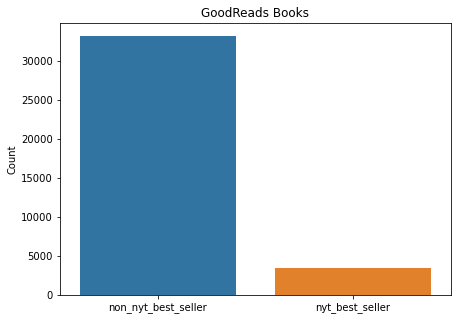

In [2125]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.barplot(['non_nyt_best_seller', 'nyt_best_seller'], 
        [best_seller_ratio[0], best_seller_ratio[1]])
plt.title('GoodReads Books')
plt.ylabel('Count');

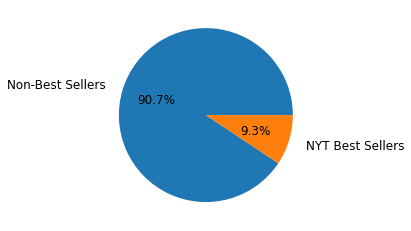

In [2900]:
plt.pie(books.nyt_best_seller.value_counts().values, labels=['Non-Best Sellers', 'NYT Best Sellers'], autopct='%1.1f%%', labeldistance=1.2);

## Publishers

In [2127]:
penguin_random = ['Avery', 'Berkley', 'Ace', 'Jove', 'New American Library (NAL)',
                  'Dutton', 'Plume', 'Obsidian', 'Onyx', 'Roc', 'Signet', 'Topaz',
                  'Cartoon Network', 'Companhia', 'Dial', 'DK', 'Alpha', 'Firebird', 
                  'Frederick', 'Putnam', 'Amy Einhorn', 'Marian Wood', 'Coward', 
                  'Grosset', 'Bedtime Stories', 'Junior Library', 'Platt', 'HP Books',
                  'Kokila', 'Dorman', 'Pelican', 'Penguin', 'Awa', 'Hamish', 'Michael Joseph',
                  'Price', 'Puffin', 'Viking', 'TarcherPerigee', 'Philomel', 'Portfolio',
                  'Razorbill', 'Riverhead', 'Sentinel', 'Speak', 'Vintage', 'Ballantine', 'Bantam',
                  'Del Rey', 'Arrow', 'Villard', 'Random', 'Delacorte', 'Doubleday', 'Knopf', 'Norton',
                  'Dell', 'Anchor', 'DAW', 'Modern Library', 'New Directions', 'NAL', 'Laurel Leaf',
                  'Yearling', 'Spectra', 'Corgi', 'Gallimard', 'Crown', 'Pantheon', 'Cape', 'Sweet Valley',
                  'Rivers', 'Harmony']

macmillan = ['Celadon', 'Farrar', 'FSG', 'Hill', 'MCD', 'North Point', 'Picador',
             'Sarah Crichton', 'Scientific American', 'Flatiron', 'Cookstr', 'Henry Holt',
             'Andy Cohen', 'Metropolitan', 'Macmillan', 'Feiwel', 'First Second – Graphic novels',
             'Imprint', 'Odd Dot', 'Priddy Books', 'Roaring Brook', 'Square Fish',
             'Swoon Reads', "St. Martin's", 'Castle Point', 'Griffin', 'Minotaur',
             'Thomas', 'Wednesday', 'Tom Doherty', 'Forge', 'Nightfire', 'Starscape',
             'Tor', 'Bloomsbury', 'Entangled', 'Graywolf', 'Guinness', 'Kingfisher', 'Page Street',
             'Papercutz', 'Martins']

harper = ['Harper', 'Amistad', 'Harlequin', 'Carina', 'Graydon', 'Hanover', 'HQN', 'Mira', 'Park Row',
          'Rogue Angel', 'Silhouette', 'Spice', 'Worldwide Mystery', 'Broadside', 'Ecco', 'Bourbon',
          'Killer', 'One More Chapter', 'Amacom', 'Estate', 'Collins', 'Borough', 'Thorsons', 'William Morrow',
          'Avon', 'Mischief', 'Custom', 'Dey', 'Witness', 'Morrow', 'Balzer', 'Bray', 'Greenwillow', 'Katherine Tegen',
          'Walden', 'Blink', 'Christian', 'Nelson', 'W Publishing', 'WestBow', 'Zonder', 'Vida', 'Caedmon', 'Bureau',
          'Unwin Hyman', 'Angus', 'Robertson', 'Julie Andrews', 'Cliff', 'Collins', 'Eos', 'Flamingo', 'Fontana',
          'Lothrop', 'Lee', 'Shepard', 'Marshall', 'Moonstone', 'Naturalist', 'Rayo', 'Regan', 'Thorsons', 'MIRA',
          'Gold Eagle']

simon_schuster = ['Adams', 'Atria', 'INK', 'Beyond', 'Cash Money', 'Emily', 'Enliven', 'Howard',
                  'Keywords', 'Marble', 'Strebor', 'Washington', 'Avid', 'Gallery', 'Karen', 'Mercury',
                  'MTV', 'North Star', 'Pocket', 'Scout', 'Threshold', 'Twelve', 'Scribner', 'Touchstone',
                  'Simon', 'Folger', 'Saga', "Children's publishing", 'Aladdin', 'Atheneum', 'Beach Lane',
                  'Margaret K. McElderry', 'Paula Wiseman', 'Salaam', 'VIZ', 'Andrews McMeel Publishing',
                  'Arcade']

hachette = ['Grand Central', 'Forever', 'Twelve', 'Vision', 'Hachette', 'Center', 'FaithWords', 'Worthy',
            'Little, Brown', 'Back Bay', 'Mulholland', 'Spark', 'Voracious', 'Patterson', 'LB Kids', 'Poppy',
            'Orbit', 'Redhook', 'Perseus', 'Avalon', 'Basic Books', 'Da Capo', 'PublicAffairs', 'Running Press',
            'Orion', 'Gollancz', 'Brown', 'Hyperion', 'Hodder', 'Warner', 'Sphere', 'Phoenix']

scholastic = ['Cartwheel', 'Chicken', 'David Fickling', 'Graphix', 'Klutz', 'Little Shepherd', 'Orchard',
              'Point', 'PUSH', 'Scholastic']

houghton = ['HMH', 'Clarion', 'Graphia', 'Mariner', 'Sandpiper', 'John Joseph Adams', 'Mariner Books', 'Houghton']

baker = ['Bethany', 'Revell', 'Baker', 'Chosen', 'Brazos Press']

amazon = ['Createspace', 'Amazon', 'CreateSpace', 'Brilliance']

dc = ['DC', 'Young Animal', 'WildStorm', 'Earth', 'Sandman', 'Wonder', 'Hill House', 'Mad', 'All Star', 'Amalgam',
      'Elseworlds', 'First Wave', 'Helix', 'Impact', 'Minx', 'Paradox', 'Piranha', 'Tangent', 'Vertigo', 'WildStorm',
      "America's Best", 'Cliffhanger', 'CMX', 'Homage', 'Zuda']

oxford = ['Oxford']

disney = ['Marvel', 'Icon', 'Infinite', 'Timely', 'Disney']

kensington = ['Kensington', 'Citadel', 'Dafina', 'John Scognamiglio', 'Pinnacle', 'Lyrical', 'Zebra']

In [2128]:
def agg_publishing_companies(df, publishing_house, replacement):
    indexes = []
    for a in publishing_house:
        for i, b in enumerate(df.publisher.tolist()):
            if a in b:
                indexes.append(i)
            else:
                pass
    df.iloc[indexes, 11] = replacement

In [2129]:
agg_publishing_companies(books, penguin_random, 'Penguin & Random')
agg_publishing_companies(books, macmillan, 'Macmillan')
agg_publishing_companies(books, simon_schuster, 'Simon & Schuster')
agg_publishing_companies(books, hachette, 'Hachette')
agg_publishing_companies(books, harper, 'HarperCollins')
agg_publishing_companies(books, scholastic, 'Scholastic')
agg_publishing_companies(books, houghton, 'HMH')
agg_publishing_companies(books, baker, 'Baker')
agg_publishing_companies(books, amazon, 'Amazon')
agg_publishing_companies(books, dc, 'DC Comics')
agg_publishing_companies(books, disney, 'Disney')
agg_publishing_companies(books, oxford, 'Oxford')
agg_publishing_companies(books, kensington, 'Kensington')

In [2130]:
top_5 = ['Penguin & Random', 'HarperCollins', 'Macmillan', 'Simon & Schuster', 'Hachette']
big_companies = ['Penguin & Random', 'HarperCollins', 'Macmillan', 'Simon & Schuster', 'Hachette', 
                 'Scholastic', 'HMH', 'Baker', 'Amazon', 'DC Comics', 'Disney', 'Oxford', 'Kensington']
def agg_big_companies(df, companies):
    indexes = []
    for i, publisher in enumerate(df.publisher.tolist()):
        if publisher not in companies:
            indexes.append(i)
        else:
            pass
    df.iloc[indexes, 11] = 'Other'

In [2131]:
agg_big_companies(books, big_companies)

In [2132]:
books.publisher.value_counts()

Other               14342
Penguin & Random     8722
HarperCollins        3527
Simon & Schuster     2389
Macmillan            2380
Hachette             2266
Amazon                817
Scholastic            713
HMH                   443
Baker                 260
DC Comics             231
Oxford                184
Kensington            176
Disney                148
Name: publisher, dtype: int64

In [2133]:
top_publisher = []

for i, publisher in enumerate(books.publisher):
    if publisher in top_5:
        top_publisher.append(1)
    else:
        top_publisher.append(0)

books['is_top_publisher'] = top_publisher

In [2134]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         36598 non-null  object 
 1   author                        36598 non-null  object 
 2   rating_count                  36598 non-null  int64  
 3   review_count                  36598 non-null  int64  
 4   average_rating                36598 non-null  float64
 5   five_star_ratings             36598 non-null  int64  
 6   four_star_ratings             36598 non-null  int64  
 7   three_star_ratings            36598 non-null  int64  
 8   two_star_ratings              36598 non-null  int64  
 9   one_star_ratings              36598 non-null  int64  
 10  number_of_pages               36598 non-null  float64
 11  publisher                     36598 non-null  object 
 12  description                   36598 non-null  object 
 13  i

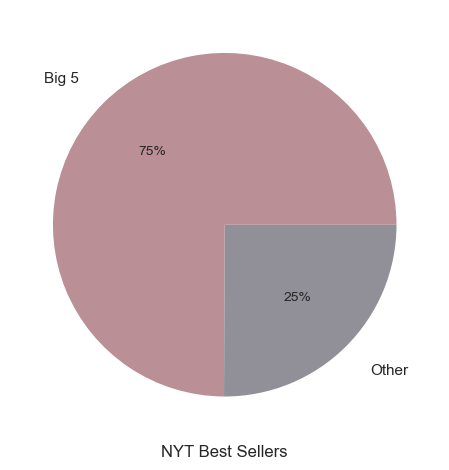

In [3064]:
# import matplotlib as mpl
mpl.rcParams['font.size'] = 14.0
plt.pie(books[books.nyt_best_seller == 1].is_top_publisher.value_counts(), labels=['Big 5', 'Other'], 
        colors=['#BA8F95', '#919098'], autopct='%1.0f%%', labeldistance=1.2)
plt.xlabel('NYT Best Sellers')
plt.tight_layout()

plt.savefig('publisher_pie_2.svg', transparent=True)

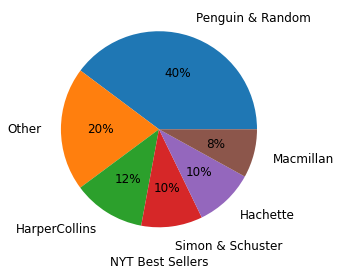

In [2842]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12.0
plt.pie(books[books.nyt_best_seller == 1].publisher.value_counts()[:6], labels=books[books.nyt_best_seller == 1].publisher.value_counts().index[:6], 
        autopct='%1.0f%%', labeldistance=1.2)
plt.xlabel('NYT Best Sellers')
plt.tight_layout()

plt.savefig('publisher_pie.svg', transparent=True)

In [2136]:
books.publisher.value_counts()

Other               14342
Penguin & Random     8722
HarperCollins        3527
Simon & Schuster     2389
Macmillan            2380
Hachette             2266
Amazon                817
Scholastic            713
HMH                   443
Baker                 260
DC Comics             231
Oxford                184
Kensington            176
Disney                148
Name: publisher, dtype: int64

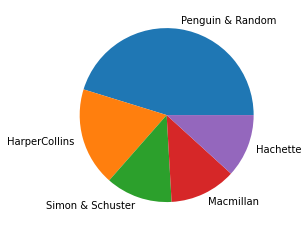

In [2145]:
plt.pie(books.publisher.value_counts()[1:6], labels=books.publisher.value_counts().index[1:6]);

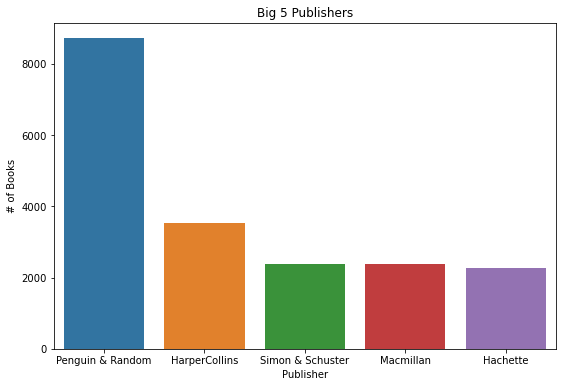

In [2146]:
plt.figure(figsize=(9, 6))
sns.barplot(books.publisher.value_counts().index[1:6], books.publisher.value_counts().values[1:6])
plt.title('Big 5 Publishers')
plt.ylabel('# of Books')
plt.xlabel('Publisher');

In [2147]:
nyt_sellers = books[books.nyt_best_seller == 1]
nyt_sellers.publisher.value_counts()

Penguin & Random    1280
Other                656
HarperCollins        384
Simon & Schuster     325
Hachette             315
Macmillan            258
Scholastic            53
Amazon                41
HMH                   35
DC Comics             23
Kensington            19
Baker                 16
Disney                 7
Oxford                 7
Name: publisher, dtype: int64

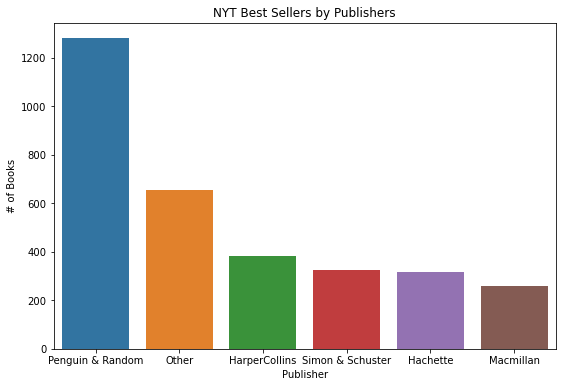

In [2148]:
plt.figure(figsize=(9, 6))
sns.barplot(nyt_sellers.publisher.value_counts().index[:6], nyt_sellers.publisher.value_counts().values[:6])
plt.title('NYT Best Sellers by Publishers')
plt.ylabel('# of Books')
plt.xlabel('Publisher');

In [2149]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         36598 non-null  object 
 1   author                        36598 non-null  object 
 2   rating_count                  36598 non-null  int64  
 3   review_count                  36598 non-null  int64  
 4   average_rating                36598 non-null  float64
 5   five_star_ratings             36598 non-null  int64  
 6   four_star_ratings             36598 non-null  int64  
 7   three_star_ratings            36598 non-null  int64  
 8   two_star_ratings              36598 non-null  int64  
 9   one_star_ratings              36598 non-null  int64  
 10  number_of_pages               36598 non-null  float64
 11  publisher                     36598 non-null  object 
 12  description                   36598 non-null  object 
 13  i

# Modeling with  `is_top_publisher`

In [2152]:
X = books.drop(columns = ['title', 'author', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings',
                          'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'publisher', 'description', 
                          'nyt_best_seller'], axis = 1)
y = books['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2153]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2154]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2155]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 2

In [2156]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.004
KNeighborsClassifier: 0.630 +- 0.006
LogisticRegression: 0.690 +- 0.015
GaussianNB: 0.683 +- 0.009
BernoulliNB: 0.661 +- 0.015
SVC: 0.618 +- 0.018
DecisionTreeClassifier: 0.592 +- 0.009
RandomForestClassifier: 0.654 +- 0.007

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.134 +- 0.006
LogisticRegression: 0.172 +- 0.009
GaussianNB: 0.161 +- 0.007
BernoulliNB: 0.159 +- 0.006
SVC: 0.128 +- 0.009
DecisionTreeClassifier: 0.125 +- 0.013
RandomForestClassifier: 0.150 +- 0.006

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.551 +- 0.009
LogisticRegression: 0.617 +- 0.023
GaussianNB: 0.576 +- 0.010
BernoulliNB: 0.622 +- 0.012
SVC: 0.538 +- 0.042
DecisionTreeClassifier: 0.572 +- 0.019
RandomForestClassifier: 0.589 +- 0.012

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.215 +- 0.009
LogisticRegression: 0.268 +- 0.011
Gauss

## Authors

In [2157]:
books.author.value_counts()

Nora Roberts                                              76
Agatha Christie                                           65
Stephen King                                              56
Bonnie Bryant                                             44
Terry Pratchett                                           44
                                                          ..
Kirsty McKay                                               1
James Stevenson                                            1
Siddharth Dhanvant Shanghvi                                1
Paul Stamets                                               1
Phyllis Bottome, Phyllis Lassner, Marilyn Hoder-Salmon     1
Name: author, Length: 19961, dtype: int64

In [2853]:
list_books = []
for author in authors.index:
    if author in best_authors.index:
        list_books.append(1)
    else:
        list_books.append(0)
len(list_books)

19961

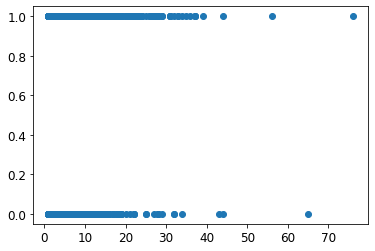

In [2855]:
plt.scatter(authors.values, list_books)
#no real correlation bewteen number of books an author published and being on the list

In [2883]:
table = books.pivot_table(index=['author'], aggfunc=[np.sum],  values=['nyt_best_seller']).reset_index()
table

,author,sum
,,nyt_best_seller
0,"50 Cent, Robert Greene",1
1,A'Mera Frieman,0
2,A. White,0
3,"A. Kirk, E. Kirk",0
4,A. Bates,0
...,...,...
19956,"Ø§Ø¨Ù ÙØ«ÙØ±, Ibn Kathir",0
19957,"Ù Ø­Ù Ø¯ Ø¨Ù ØµØ§ÙØ­ Ø§ÙØ¹Ø«ÙÙ ÙÙ, Darus...",0
19958,"Ù Ø­Ù Ø¯ Ø¹Ø¨Ø¯Ø§ÙØ±Ø­Ù Ù Ø§ÙØ¹Ø±ÙÙÙ, Da...",0


In [2890]:
table[table[(   'sum', 'nyt_best_seller')]>1]

,author,sum
,,nyt_best_seller
35,A.G. Howard,2
77,A.S. Byatt,3
102,Abbi Glines,7
326,Alan Bradley,5
528,Alexandra Bracken,2
...,...,...
19763,Yana Toboso,6
19764,"Yana Toboso, Tomo Kimura",4
19765,Yann Martel,2


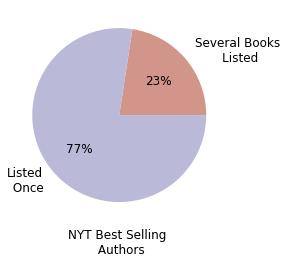

In [2941]:
multiple_listers = len(table[table[(   'sum', 'nyt_best_seller')]>1])
num_first_timers = len(table[table[(   'sum', 'nyt_best_seller')]==1])
mpl.rcParams['font.size'] = 12.0
labels = ['Several Books\n       Listed', 'Listed\n Once']
colors = ['#d29589', '#BAB9D8']
plt.pie([multiple_listers, num_first_timers], labels=labels,colors=colors, autopct='%1.0f%%', labeldistance=1.15)
plt.xlabel('NYT Best Selling \n Authors')
plt.savefig('authors.svg', transparent=True)

(array([347.,  84.,  21.,  23.,   7.,   6.,   4.,   4.,   1.,   1.]),
 array([ 2. ,  3.6,  5.2,  6.8,  8.4, 10. , 11.6, 13.2, 14.8, 16.4, 18. ]),
 <a list of 10 Patch objects>)

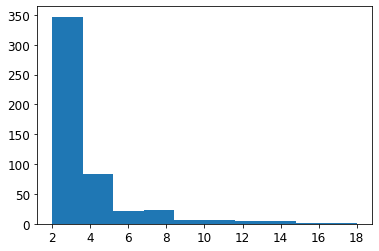

In [2910]:
plt.hist(table[table[(   'sum', 'nyt_best_seller')]>1][(   'sum', 'nyt_best_seller')])

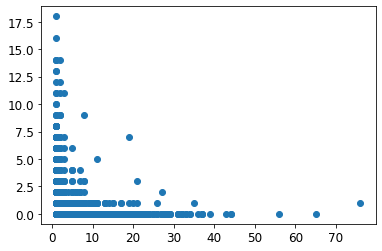

In [2874]:
plt.scatter(authors.values, table[(   'sum', 'nyt_best_seller')])

In [2872]:
best_authors

Nora Roberts                18
Sherrilyn Kenyon            16
J.R. Ward                   14
Stephen King                14
Nalini Singh                14
                            ..
Joyce Moyer Hostetter        1
Jenn Reese                   1
Vanessa Waltz                1
S.A. Bodeen                  1
Fern Michaels, Tanya Eby     1
Name: author, Length: 2206, dtype: int64

In [2847]:
authors = books.author.value_counts()
best_authors = books[books.nyt_best_seller == 1].author.value_counts()

AttributeError: 'int' object has no attribute 'index'

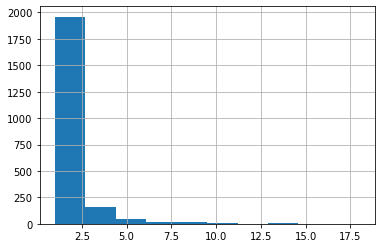

In [2158]:
books[books.nyt_best_seller == 1].author.value_counts().hist();

In [2160]:
mask = books[books.nyt_best_seller == 1].author.value_counts() > 5
best_selling_authors = books[books.nyt_best_seller == 1].author.value_counts()[mask].index

In [2161]:
best_selling_authors

Index(['Nora Roberts', 'Sherrilyn Kenyon', 'J.R. Ward', 'Stephen King',
       'Nalini Singh', 'David Baldacci', 'Jim Butcher', 'J.D. Robb',
       'Gena Showalter', 'Christine Feehan', 'Brandon Sanderson',
       'Charlaine Harris', 'Patricia Briggs', 'Nicholas Sparks',
       'Jodi Picoult', 'Lee Child', 'Christina Lauren', 'Alice Hoffman',
       'Michael Connelly', 'Catherine Anderson', 'Daniel Silva',
       'Jeffrey Archer', 'Lynsay Sands', 'Karen Kingsbury', 'Karen      Rose',
       'Terry Brooks', 'Laurell K. Hamilton', 'Kresley Cole', 'Ted Dekker',
       'Jennifer L. Armentrout', 'Harlan Coben', 'Richard Paul Evans',
       'John Grisham', 'Karen Marie Moning', 'Seanan McGuire', 'Neil Gaiman',
       'C.J. Box', 'Sophie Kinsella', 'Dean Koontz', 'Danielle Steel',
       'Ilona Andrews', 'Kim Harrison', 'Abbi Glines', 'Lara Adrian',
       'Kerrelyn Sparks', 'Lisa Kleypas', 'Yasmine Galenorn', 'James Rollins',
       'Maeve Binchy', 'John Irving', 'Dave Eggers', 'Margaret Atw

In [2162]:
is_best_selling_author = []
for row in books.author:
    if row in best_selling_authors:
        is_best_selling_author.append(1)
    else:
        is_best_selling_author.append(0)
books['is_best_selling_author'] = is_best_selling_author

In [2163]:
books.is_best_selling_author.value_counts()

0    35140
1     1458
Name: is_best_selling_author, dtype: int64

In [2164]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         36598 non-null  object 
 1   author                        36598 non-null  object 
 2   rating_count                  36598 non-null  int64  
 3   review_count                  36598 non-null  int64  
 4   average_rating                36598 non-null  float64
 5   five_star_ratings             36598 non-null  int64  
 6   four_star_ratings             36598 non-null  int64  
 7   three_star_ratings            36598 non-null  int64  
 8   two_star_ratings              36598 non-null  int64  
 9   one_star_ratings              36598 non-null  int64  
 10  number_of_pages               36598 non-null  float64
 11  publisher                     36598 non-null  object 
 12  description                   36598 non-null  object 
 13  i

# Modeling with `is_best_selling_author`

In [2166]:
X = books.drop(columns = ['title', 'author', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings',
                          'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'publisher', 'description', 
                          'nyt_best_seller'], axis = 1)
y = books['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2167]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2168]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2169]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 3

In [2170]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.004
KNeighborsClassifier: 0.642 +- 0.009
LogisticRegression: 0.727 +- 0.007
GaussianNB: 0.740 +- 0.011
BernoulliNB: 0.681 +- 0.026
SVC: 0.618 +- 0.018
DecisionTreeClassifier: 0.604 +- 0.004
RandomForestClassifier: 0.664 +- 0.009

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.138 +- 0.006
LogisticRegression: 0.191 +- 0.006
GaussianNB: 0.184 +- 0.014
BernoulliNB: 0.173 +- 0.004
SVC: 0.128 +- 0.007
DecisionTreeClassifier: 0.130 +- 0.006
RandomForestClassifier: 0.154 +- 0.004

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.552 +- 0.028
LogisticRegression: 0.606 +- 0.013
GaussianNB: 0.529 +- 0.017
BernoulliNB: 0.653 +- 0.027
SVC: 0.540 +- 0.030
DecisionTreeClassifier: 0.581 +- 0.009
RandomForestClassifier: 0.590 +- 0.028

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.221 +- 0.008
LogisticRegression: 0.291 +- 0.009
Gauss

# Textblob semantics

In [2171]:
from textblob import TextBlob

In [2172]:
title_semantics = []
desc_semantics = []
for title, desc in zip(books.title, books.description):
    title_blob = TextBlob(title)
    desc_blob = TextBlob(desc)
    title_semantics.append(title_blob.sentiment.polarity)
    desc_semantics.append(desc_blob.sentiment.polarity)

In [2173]:
books['title_semantic'] = title_semantics
books['desc_semantic'] = desc_semantics

In [1265]:
books.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,Mystery,Nonfiction,Other,Romance,Science Fiction,Young Adult,is_top_publisher,is_best_selling_author,title_semantic,desc_semantic
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,0,0,0,0,0,1,1,0,0.000000,0.164876
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,0,0,1,0,0,0,1,1,0.000000,0.088839
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,0,0,1,0,0,0,1,0,0.400000,0.425000
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,0,0,0,1,0,0,1,0,-0.166667,0.157778
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,0,0,0,1,0,0,1,0,0.000000,0.273281


# Modeling with Semantics

In [2175]:
X = books.drop(columns = ['title', 'author', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings',
                          'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'publisher', 'description', 
                          'nyt_best_seller'], axis = 1)
y = books['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2176]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2177]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2178]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 4

In [2179]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.005
KNeighborsClassifier: 0.639 +- 0.003
LogisticRegression: 0.730 +- 0.009
GaussianNB: 0.740 +- 0.013
BernoulliNB: 0.679 +- 0.018
SVC: 0.610 +- 0.012
DecisionTreeClassifier: 0.605 +- 0.005
RandomForestClassifier: 0.692 +- 0.006

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.137 +- 0.008
LogisticRegression: 0.192 +- 0.012
GaussianNB: 0.184 +- 0.015
BernoulliNB: 0.171 +- 0.015
SVC: 0.126 +- 0.005
DecisionTreeClassifier: 0.130 +- 0.006
RandomForestClassifier: 0.171 +- 0.003

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.552 +- 0.033
LogisticRegression: 0.602 +- 0.021
GaussianNB: 0.527 +- 0.015
BernoulliNB: 0.643 +- 0.010
SVC: 0.544 +- 0.018
DecisionTreeClassifier: 0.578 +- 0.020
RandomForestClassifier: 0.612 +- 0.021

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.220 +- 0.012
LogisticRegression: 0.291 +- 0.016
Gauss

# Feature ENgineering

In [2180]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         36598 non-null  object 
 1   author                        36598 non-null  object 
 2   rating_count                  36598 non-null  int64  
 3   review_count                  36598 non-null  int64  
 4   average_rating                36598 non-null  float64
 5   five_star_ratings             36598 non-null  int64  
 6   four_star_ratings             36598 non-null  int64  
 7   three_star_ratings            36598 non-null  int64  
 8   two_star_ratings              36598 non-null  int64  
 9   one_star_ratings              36598 non-null  int64  
 10  number_of_pages               36598 non-null  float64
 11  publisher                     36598 non-null  object 
 12  description                   36598 non-null  object 
 13  i

In [2181]:
books['5_to_1_star_ratio'] = books.five_star_ratings / (books.one_star_ratings+0.1)

In [2182]:
books.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,Nonfiction,Other,Romance,Science Fiction,Young Adult,is_top_publisher,is_best_selling_author,title_semantic,desc_semantic,5_to_1_star_ratio
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,0,0,0,0,1,1,0,0.000000,0.164876,33.061889
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,0,1,0,0,0,1,1,0.000000,0.088839,68.027211
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,0,1,0,0,0,1,0,0.400000,0.425000,25.406500
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,0,0,1,0,0,1,0,-0.166667,0.157778,52.266244
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,0,0,1,0,0,1,0,0.000000,0.273281,40.718189


/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


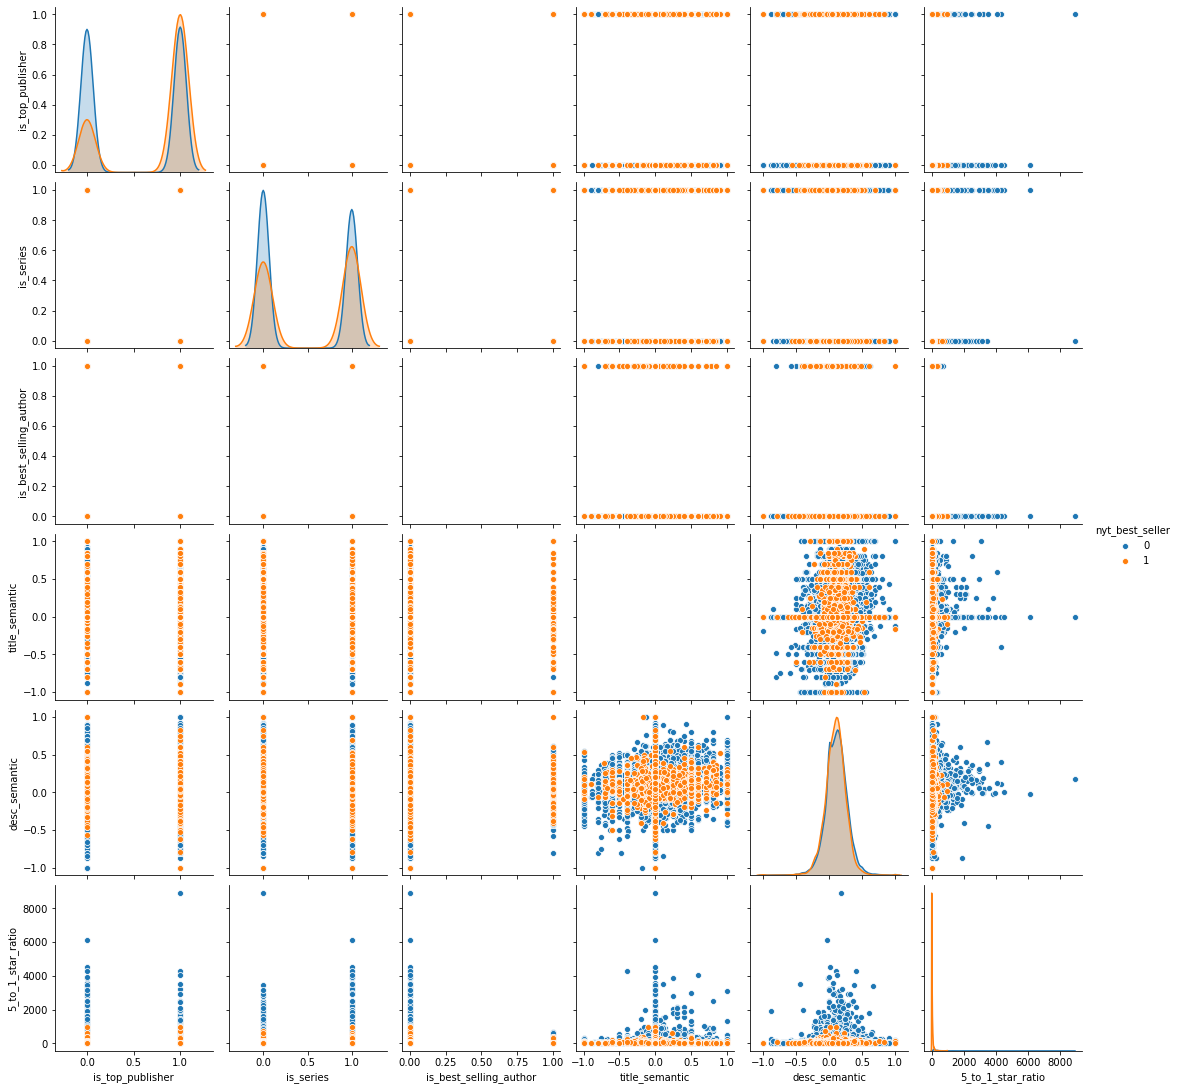

In [2183]:
sns.pairplot(books, vars = ["is_top_publisher", "is_series", "is_best_selling_author", "title_semantic", "desc_semantic",
                            "5_to_1_star_ratio"], hue = 'nyt_best_seller')

In [2184]:
X = books.drop(columns = ['title', 'author', 'rating_count', 'review_count', 'five_star_ratings', 'four_star_ratings',
                          'three_star_ratings', 'two_star_ratings', 'one_star_ratings', 'publisher', 'description', 
                          'nyt_best_seller'], axis = 1)
y = books['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2185]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2186]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2187]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 5

In [2188]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.002
KNeighborsClassifier: 0.588 +- 0.007
LogisticRegression: 0.722 +- 0.006
GaussianNB: 0.669 +- 0.015
BernoulliNB: 0.693 +- 0.019
SVC: 0.621 +- 0.013
DecisionTreeClassifier: 0.604 +- 0.008
RandomForestClassifier: 0.701 +- 0.008

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.116 +- 0.007
LogisticRegression: 0.189 +- 0.006
GaussianNB: 0.164 +- 0.009
BernoulliNB: 0.177 +- 0.010
SVC: 0.129 +- 0.008
DecisionTreeClassifier: 0.130 +- 0.008
RandomForestClassifier: 0.179 +- 0.005

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.522 +- 0.017
LogisticRegression: 0.612 +- 0.026
GaussianNB: 0.633 +- 0.015
BernoulliNB: 0.635 +- 0.029
SVC: 0.541 +- 0.020
DecisionTreeClassifier: 0.580 +- 0.008
RandomForestClassifier: 0.627 +- 0.016

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.189 +- 0.010
LogisticRegression: 0.289 +- 0.009
Gauss

DummyClassifier AUC: 0.500
KNeighborsClassifier AUC: 0.835


/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression AUC: 0.718
GaussianNB AUC: 0.694
BernoulliNB AUC: 0.714
DecisionTreeClassifier AUC: 0.918
RandomForestClassifier AUC: 0.970


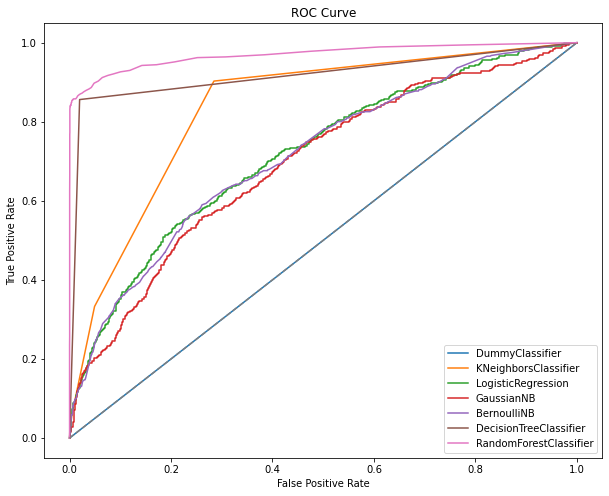

In [2191]:
plt.figure(figsize=(10,8))

for model in models:
    name = str(model).split('(')[0]
    ml = model
    ml.fit(X_tr, y_tr)
    
    fpr, tpr, _ = roc_curve(y_val, ml.predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr, label=name)
    print(f'{name} AUC: {auc(fpr, tpr):.3f}')
    
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

# More Feature Extraction from text data

In [2192]:
books2 = books.copy()

In [2193]:
books2['title_word_count'] = books2['title'].apply(lambda x: len(str(x).split(" ")))

In [2194]:
books2.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,Other,Romance,Science Fiction,Young Adult,is_top_publisher,is_best_selling_author,title_semantic,desc_semantic,5_to_1_star_ratio,title_word_count
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,0,0,0,1,1,0,0.000000,0.164876,33.061889,2
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,1,0,0,0,1,1,0.000000,0.088839,68.027211,2
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,1,0,0,0,1,0,0.400000,0.425000,25.406500,10
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,0,1,0,0,1,0,-0.166667,0.157778,52.266244,2
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,0,1,0,0,1,0,0.000000,0.273281,40.718189,1


In [2195]:
def text_preprocess(string):
    string = string.lower()
    string = re.sub('[^0-9a-zA-Z]+', ' ', string).strip()
    return string
books2['description_processed'] = books2['description'].apply(text_preprocess)

In [2196]:
books2.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,Romance,Science Fiction,Young Adult,is_top_publisher,is_best_selling_author,title_semantic,desc_semantic,5_to_1_star_ratio,title_word_count,description_processed
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,0,0,1,1,0,0.000000,0.164876,33.061889,2,reed brennan arrived at easton academy expecti...
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,0,0,0,1,1,0.000000,0.088839,68.027211,2,filmmakers chase ryan and keith ellison have c...
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,0,0,0,1,0,0.400000,0.425000,25.406500,10,the incredible national bestseller that is cha...
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,1,0,0,1,0,-0.166667,0.157778,52.266244,2,with her high spirited intelligence and good l...
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,1,0,0,1,0,0.000000,0.273281,40.718189,1,when the news went out that sylvester rayne th...


In [2197]:
def desc_len(string):
    return len(string.split(' '))

def num_unique_words(string):
    return len(set(string.split(' ')))
    
def avg_word_len(string):
    return np.mean([len(word) for word in string.split(' ')])

In [2198]:
books2['desc_len'] = books2['description_processed'].apply(desc_len)
books2['num_unique_words'] = books2['description_processed'].apply(num_unique_words)
books2['avg_word_len'] = books2['description_processed'].apply(avg_word_len)

In [2199]:
books2.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,is_top_publisher,is_best_selling_author,title_semantic,desc_semantic,5_to_1_star_ratio,title_word_count,description_processed,desc_len,num_unique_words,avg_word_len
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,1,0,0.000000,0.164876,33.061889,2,reed brennan arrived at easton academy expecti...,215,113,4.981395
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,1,1,0.000000,0.088839,68.027211,2,filmmakers chase ryan and keith ellison have c...,197,85,4.629442
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,1,0,0.400000,0.425000,25.406500,10,the incredible national bestseller that is cha...,30,15,5.533333
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,1,0,-0.166667,0.157778,52.266244,2,with her high spirited intelligence and good l...,261,124,4.835249
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,1,0,0.000000,0.273281,40.718189,1,when the news went out that sylvester rayne th...,377,178,4.599469


In [2203]:
X = books2.drop(columns=['title', 'author', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings', 'nyt_best_seller'], axis=1)
y = books2['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2204]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2205]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2206]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 6

In [2207]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.004
KNeighborsClassifier: 0.582 +- 0.008
LogisticRegression: 0.724 +- 0.010
GaussianNB: 0.625 +- 0.010
BernoulliNB: 0.689 +- 0.017
SVC: 0.642 +- 0.009
DecisionTreeClassifier: 0.623 +- 0.009
RandomForestClassifier: 0.716 +- 0.013

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.117 +- 0.003
LogisticRegression: 0.198 +- 0.010
GaussianNB: 0.155 +- 0.008
BernoulliNB: 0.175 +- 0.011
SVC: 0.140 +- 0.006
DecisionTreeClassifier: 0.139 +- 0.009
RandomForestClassifier: 0.194 +- 0.010

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.539 +- 0.018
LogisticRegression: 0.654 +- 0.019
GaussianNB: 0.691 +- 0.029
BernoulliNB: 0.639 +- 0.016
SVC: 0.560 +- 0.016
DecisionTreeClassifier: 0.598 +- 0.028
RandomForestClassifier: 0.659 +- 0.026

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.192 +- 0.005
LogisticRegression: 0.304 +- 0.010
Gauss

In [2208]:
model.feature_importances_

array([0.08646656, 0.10564314, 0.01654801, 0.04679356, 0.00892039,
       0.01294279, 0.00564323, 0.00705525, 0.0048378 , 0.01510273,
       0.00791898, 0.00472657, 0.00623253, 0.04200684, 0.03274382,
       0.03293624, 0.09753298, 0.09650226, 0.08054592, 0.0971463 ,
       0.0945164 , 0.09723773])

# Text Readability

In [1136]:
# package to measure text readability, complexity and grade level
!pip install textstat

In [2209]:
from textstat import syllable_count, lexicon_count, sentence_count, flesch_reading_ease
                    
books2['syllable_count'] = books2.description.apply(syllable_count)
books2['lexicon_count'] = books2.description.apply(lexicon_count)
books2['sentence_count'] = books2.description.apply(sentence_count)
books2['flesch_reading_ease'] = books2.description.apply(flesch_reading_ease)

In [2210]:
books2.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,5_to_1_star_ratio,title_word_count,description_processed,desc_len,num_unique_words,avg_word_len,syllable_count,lexicon_count,sentence_count,flesch_reading_ease
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,33.061889,2,reed brennan arrived at easton academy expecti...,215,113,4.981395,335,210,8,44.78
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,68.027211,2,filmmakers chase ryan and keith ellison have c...,197,85,4.629442,278,193,7,60.38
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,25.406500,10,the incredible national bestseller that is cha...,30,15,5.533333,52,28,1,17.68
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,52.266244,2,with her high spirited intelligence and good l...,261,124,4.835249,379,248,13,60.55
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,40.718189,1,when the news went out that sylvester rayne th...,377,178,4.599469,514,369,21,70.53


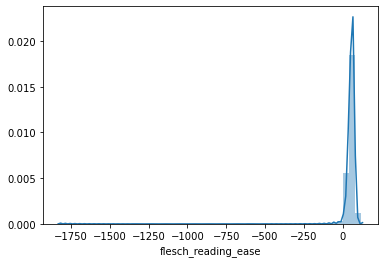

In [2212]:
sns.distplot(books2.flesch_reading_ease)

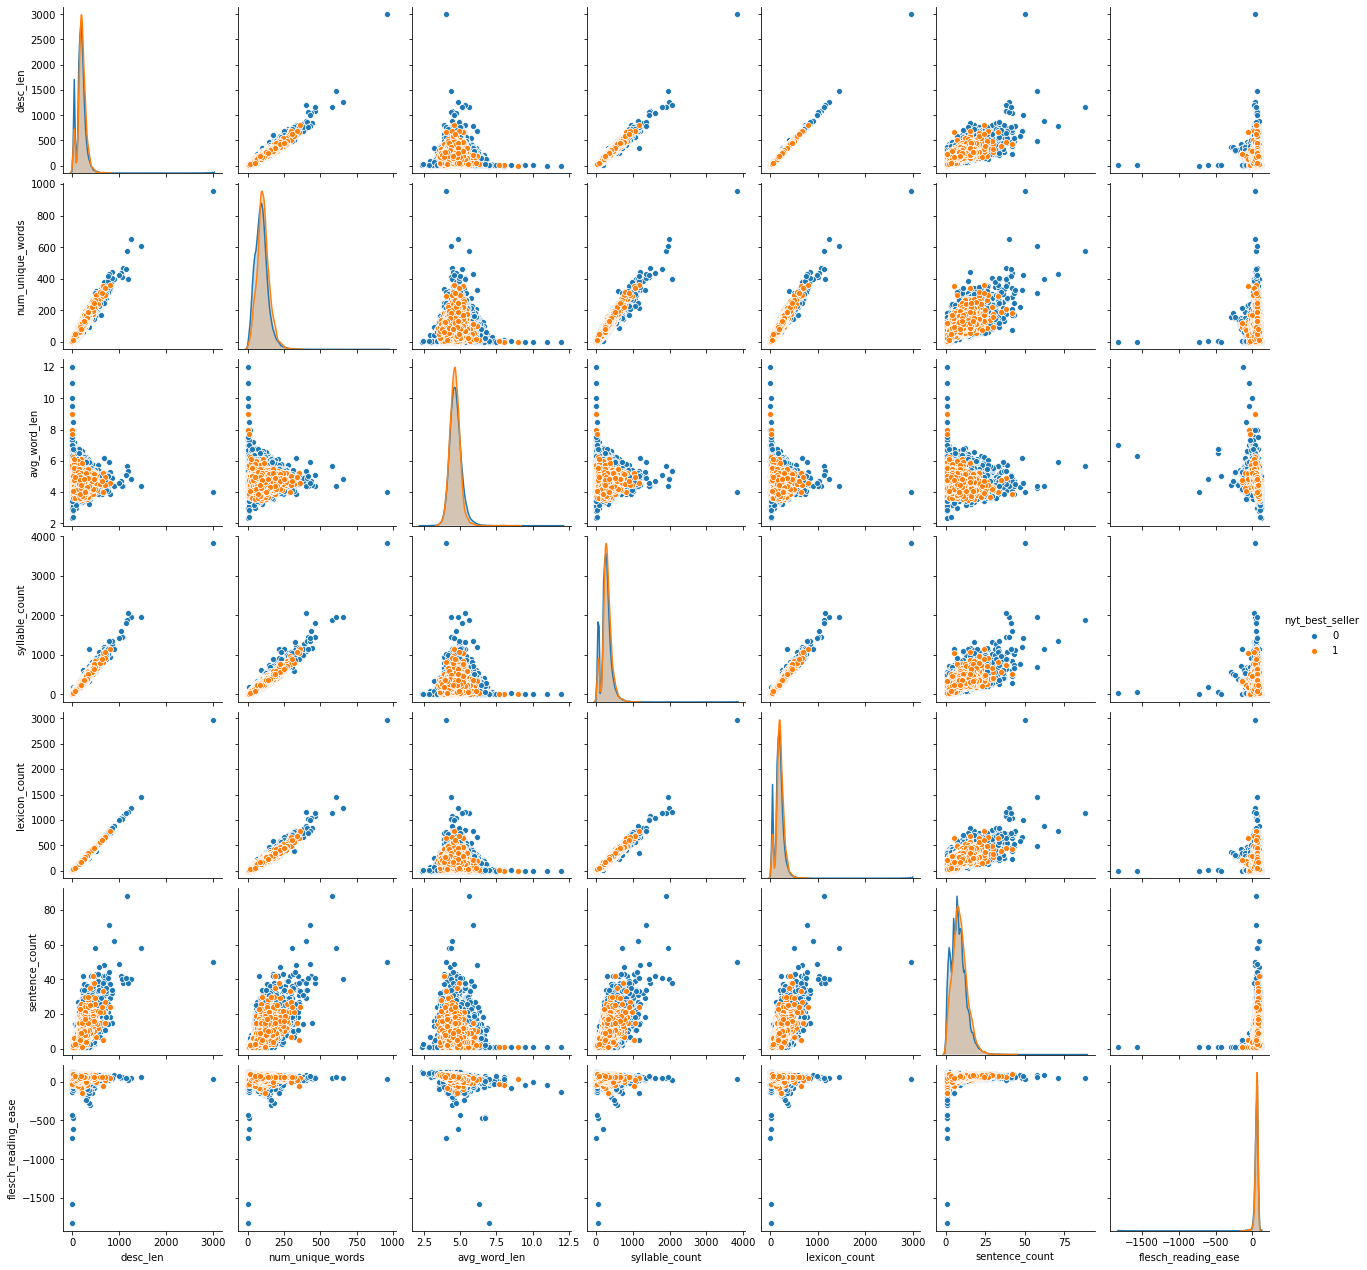

In [2215]:
sns.pairplot(books2, vars = ["desc_len", "num_unique_words", "avg_word_len", "syllable_count",
                            "lexicon_count", "sentence_count", "flesch_reading_ease"], hue = 'nyt_best_seller')

In [2216]:
X = books2.drop(columns=['title', 'author', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings', 'nyt_best_seller'], axis=1)
y = books2['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2217]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2218]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2219]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 7

In [2220]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.003
KNeighborsClassifier: 0.576 +- 0.009
LogisticRegression: 0.720 +- 0.005
GaussianNB: 0.617 +- 0.014
BernoulliNB: 0.697 +- 0.003
SVC: 0.645 +- 0.015
DecisionTreeClassifier: 0.614 +- 0.010
RandomForestClassifier: 0.713 +- 0.008

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.118 +- 0.004
LogisticRegression: 0.196 +- 0.010
GaussianNB: 0.153 +- 0.006
BernoulliNB: 0.179 +- 0.008
SVC: 0.141 +- 0.011
DecisionTreeClassifier: 0.135 +- 0.006
RandomForestClassifier: 0.191 +- 0.008

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.555 +- 0.010
LogisticRegression: 0.660 +- 0.020
GaussianNB: 0.699 +- 0.019
BernoulliNB: 0.635 +- 0.012
SVC: 0.556 +- 0.014
DecisionTreeClassifier: 0.589 +- 0.009
RandomForestClassifier: 0.654 +- 0.019

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.194 +- 0.005
LogisticRegression: 0.303 +- 0.013
Gauss

In [2221]:
model.feature_importances_

array([0.06731929, 0.08199853, 0.01207992, 0.04154476, 0.00823125,
       0.01061085, 0.00432105, 0.00382402, 0.00401437, 0.01159265,
       0.00580737, 0.00291845, 0.00488745, 0.0385397 , 0.02940259,
       0.02417779, 0.07035157, 0.06942745, 0.07896991, 0.05944572,
       0.06464623, 0.07186196, 0.06088378, 0.06146546, 0.04314255,
       0.06853534])

## Removing Stopwords

In [2222]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilyng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/emilyng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2223]:
stop = stopwords.words('english')

def num_non_stop_words(x):
    return len([x for x in x.split() if x not in stop])

def unique_non_stop_words(x):
    return len(set([x for x in x.split() if x not in stop]))

def num_stop_words(x):
    return len([x for x in x.split() if x in stop])

def unique_stop_words(x):
    return len(set([x for x in x.split() if x not in stop]))

#books['num_non_stop'] = books['description_processed'].apply(num_non_stop_words)
#books['unique_non_stop'] = books['description_processed'].apply(unique_non_stop_words)
#books['num_stop'] = books['description_processed'].apply(num_stop_words)
#books['unique_stop'] = books['description_processed'].apply(unique_stop_words)
books2['des_no_stops'] = books2['description_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [2224]:
books2.head()

,title,author,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,...,title_word_count,description_processed,desc_len,num_unique_words,avg_word_len,syllable_count,lexicon_count,sentence_count,flesch_reading_ease,des_no_stops
0,inner circle,"Kate Brian, Julian Peploe",7597,196,4.03,3045,2323,1748,389,92,...,2,reed brennan arrived at easton academy expecti...,215,113,4.981395,335,210,8,44.78,reed brennan arrived easton academy expecting ...
1,take two,Karen Kingsbury,6288,218,4.23,3000,2020,1041,183,44,...,2,filmmakers chase ryan and keith ellison have c...,197,85,4.629442,278,193,7,60.38,filmmakers chase ryan keith ellison completed ...
2,the millionaire next door: the surprising secr...,"Thomas J. Stanley, William D. Danko",72168,3217,4.04,27594,25219,14855,3414,1086,...,10,the incredible national bestseller that is cha...,30,15,5.533333,52,28,1,17.68,incredible national bestseller changing people...
3,black sheep,Georgette Heyer,9538,775,4.05,3298,3831,2042,304,63,...,2,with her high spirited intelligence and good l...,261,124,4.835249,379,248,13,60.55,high spirited intelligence good looks abigail ...
4,sylvester,"Georgette Heyer, Joan Wolf",13473,1141,4.11,5216,5225,2470,434,128,...,1,when the news went out that sylvester rayne th...,377,178,4.599469,514,369,21,70.53,news went sylvester rayne elegant impeccable d...


## Remove most frequent words

In [2225]:
freq = pd.Series(' '.join(books2['des_no_stops']).split()).value_counts()[:10]
freq = list(freq.index)
books2['des_no_stops'] = books2['des_no_stops'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
books2['des_no_stops'].head()

0    reed brennan arrived easton academy expecting ...
1    filmmakers chase ryan keith ellison completed ...
2    incredible national bestseller changing people...
3    high spirited intelligence good looks abigail ...
4    news went sylvester rayne elegant impeccable d...
Name: des_no_stops, dtype: object

In [2226]:
freq

['one',
 'life',
 'new',
 'world',
 'love',
 'book',
 'story',
 'time',
 'first',
 'years']

## Remove least frequent words

In [2227]:
freq = pd.Series(' '.join(books2['des_no_stops']).split()).value_counts()[-10:]
freq = list(freq.index)
books2['des_no_stops'] = books2['des_no_stops'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
books2['des_no_stops'].head()

0    reed brennan arrived easton academy expecting ...
1    filmmakers chase ryan keith ellison completed ...
2    incredible national bestseller changing people...
3    high spirited intelligence good looks abigail ...
4    news went sylvester rayne elegant impeccable d...
Name: des_no_stops, dtype: object

In [2228]:
freq

['deareven',
 'overeat',
 'kazamand',
 'rubbia',
 'blaisdell',
 'frankenfoods',
 'starstuff',
 'medalists',
 'ironisnya',
 'charleson']

## Lemmatization

In [2229]:
from textblob import Word
books2['des_no_stops'] = books2['des_no_stops'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
books2['des_no_stops'].head()

0    reed brennan arrived easton academy expecting ...
1    filmmaker chase ryan keith ellison completed f...
2    incredible national bestseller changing people...
3    high spirited intelligence good look abigail w...
4    news went sylvester rayne elegant impeccable d...
Name: des_no_stops, dtype: object

In [2230]:
books2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36598 entries, 0 to 36597
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   title                         36598 non-null  object 
 1   author                        36598 non-null  object 
 2   rating_count                  36598 non-null  int64  
 3   review_count                  36598 non-null  int64  
 4   average_rating                36598 non-null  float64
 5   five_star_ratings             36598 non-null  int64  
 6   four_star_ratings             36598 non-null  int64  
 7   three_star_ratings            36598 non-null  int64  
 8   two_star_ratings              36598 non-null  int64  
 9   one_star_ratings              36598 non-null  int64  
 10  number_of_pages               36598 non-null  float64
 11  publisher                     36598 non-null  object 
 12  description                   36598 non-null  object 
 13  i

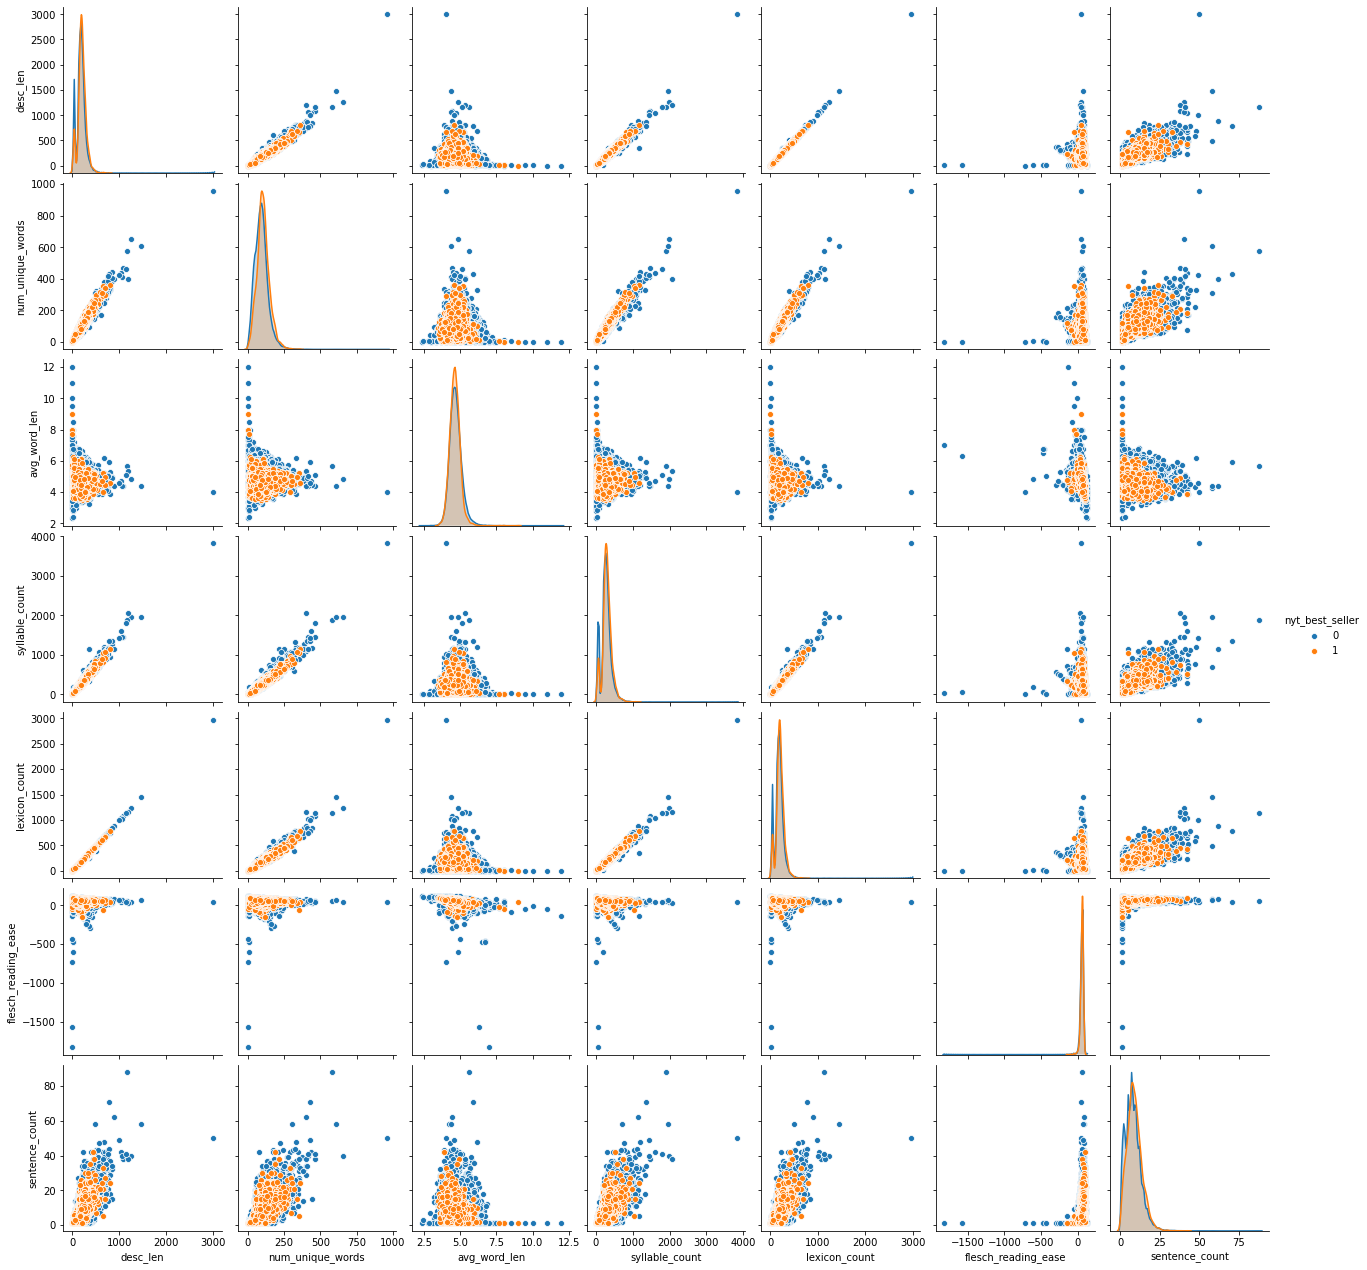

In [2232]:
sns.pairplot(books2, vars = ['desc_len', 'num_unique_words', 'avg_word_len', 'syllable_count', 'lexicon_count', 
                            'flesch_reading_ease', 'sentence_count'], 
                             hue = 'nyt_best_seller')

# Modelign on Added Text Features

In [2234]:
books2.select_dtypes('number')

,rating_count,review_count,average_rating,five_star_ratings,four_star_ratings,three_star_ratings,two_star_ratings,one_star_ratings,number_of_pages,is_series,...,desc_semantic,5_to_1_star_ratio,title_word_count,desc_len,num_unique_words,avg_word_len,syllable_count,lexicon_count,sentence_count,flesch_reading_ease
0,7597,196,4.03,3045,2323,1748,389,92,220.0,1,...,0.164876,33.061889,2,215,113,4.981395,335,210,8,44.78
1,6288,218,4.23,3000,2020,1041,183,44,320.0,1,...,0.088839,68.027211,2,197,85,4.629442,278,193,7,60.38
2,72168,3217,4.04,27594,25219,14855,3414,1086,258.0,0,...,0.425000,25.406500,10,30,15,5.533333,52,28,1,17.68
3,9538,775,4.05,3298,3831,2042,304,63,252.0,0,...,0.157778,52.266244,2,261,124,4.835249,379,248,13,60.55
4,13473,1141,4.11,5216,5225,2470,434,128,410.0,0,...,0.273281,40.718189,1,377,178,4.599469,514,369,21,70.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36593,37504,1763,4.05,13144,15566,7000,1251,543,413.0,1,...,0.033929,24.201804,3,245,129,4.612245,319,234,10,64.64
36594,82013,2409,4.15,31479,34321,13865,1804,544,14.0,1,...,0.214286,57.855174,2,131,53,4.625954,178,125,9,74.29
36595,11894,793,4.15,5227,4031,2032,453,151,447.0,1,...,0.047222,34.592985,2,182,81,4.483516,246,176,9,68.50
36596,42609,4282,3.84,12461,15191,11202,3011,744,208.0,0,...,0.118290,16.746405,7,283,133,4.561837,420,279,10,51.62


In [2288]:
X = books2.drop(columns=['title', 'author', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings', 'des_no_stops', 'nyt_best_seller'], axis=1)
y = books2['nyt_best_seller']
y = books2['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2289]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2290]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2291]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

## Model 8

In [2297]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='saga', max_iter=500), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear', max_iter=500):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0.1))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.5, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0.1))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.907 +- 0.004
KNeighborsClassifier: 0.577 +- 0.017
LogisticRegression: 0.630 +- 0.018
GaussianNB: 0.630 +- 0.031
BernoulliNB: 0.694 +- 0.031
SVC: 0.626 +- 0.013
DecisionTreeClassifier: 0.617 +- 0.006
RandomForestClassifier: 0.717 +- 0.010

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.115 +- 0.009
LogisticRegression: 0.135 +- 0.009
GaussianNB: 0.156 +- 0.010
BernoulliNB: 0.179 +- 0.020
SVC: 0.135 +- 0.007
DecisionTreeClassifier: 0.136 +- 0.008
RandomForestClassifier: 0.197 +- 0.012

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.532 +- 0.018
LogisticRegression: 0.552 +- 0.037
GaussianNB: 0.675 +- 0.035
BernoulliNB: 0.638 +- 0.022
SVC: 0.561 +- 0.039
DecisionTreeClassifier: 0.588 +- 0.029
RandomForestClassifier: 0.670 +- 0.032

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.189 +- 0.011
LogisticRegression: 0.216 +- 0.012
Gauss

DummyClassifier AUC: 0.500
KNeighborsClassifier AUC: 0.829


/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression AUC: 0.571
GaussianNB AUC: 0.714
BernoulliNB AUC: 0.717
SVC AUC: 0.643
DecisionTreeClassifier AUC: 0.917
RandomForestClassifier AUC: 0.975


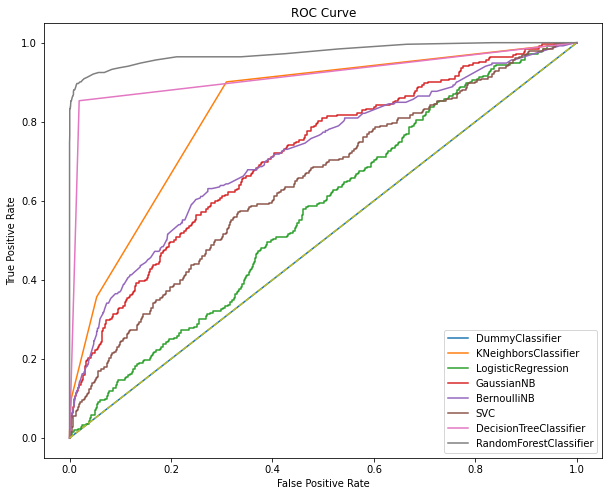

In [2298]:
plt.figure(figsize=(10,8))

for model in models:
    name = str(model).split('(')[0]
    ml = model
    ml.fit(X_tr, y_tr)
    
    fpr, tpr, _ = roc_curve(y_val, ml.predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr, label=name)
    print(f'{name} AUC: {auc(fpr, tpr):.3f}')
    
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend();

In [2299]:
model.feature_importances_

array([0.07140622, 0.08044178, 0.01083843, 0.02215957, 0.00655176,
       0.0101296 , 0.00492559, 0.00583826, 0.00423176, 0.00984746,
       0.00568999, 0.00252315, 0.00466901, 0.01575896, 0.03299642,
       0.03219747, 0.08020967, 0.07776438, 0.04357031, 0.06638675,
       0.06996627, 0.07967778, 0.07211544, 0.06687883, 0.04701403,
       0.07621111])

### Threshold > 0.8

In [2300]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='saga', max_iter=500), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear', max_iter=500):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0.1))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0.1))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.905 +- 0.007
KNeighborsClassifier: 0.878 +- 0.006
LogisticRegression: 0.904 +- 0.008
GaussianNB: 0.734 +- 0.026
BernoulliNB: 0.884 +- 0.008
SVC: 0.905 +- 0.007
DecisionTreeClassifier: 0.608 +- 0.014
RandomForestClassifier: 0.899 +- 0.005

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.149 +- 0.016
LogisticRegression: 0.139 +- 0.171
GaussianNB: 0.192 +- 0.018
BernoulliNB: 0.341 +- 0.060
SVC: 0.000 +- 0.000
DecisionTreeClassifier: 0.137 +- 0.010
RandomForestClassifier: 0.418 +- 0.094

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.063 +- 0.015
LogisticRegression: 0.004 +- 0.007
GaussianNB: 0.561 +- 0.027
BernoulliNB: 0.223 +- 0.027
SVC: 0.000 +- 0.000
DecisionTreeClassifier: 0.591 +- 0.023
RandomForestClassifier: 0.120 +- 0.015

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.089 +- 0.017
LogisticRegression: 0.008 +- 0.013
Gauss

# TF-IDF

### Logistic Regression to find best text predictors

In [2301]:
X_text = np.array(books2.des_no_stops).reshape(-1,1)
y_text = books2.nyt_best_seller
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.2, random_state=42)

In [2302]:
X_text_tr, X_text_val, y_text_tr, y_text_val = train_test_split(X_text_train, y_text_train, test_size = 0.2)

In [2398]:
from sklearn.linear_model import LogisticRegression

def imb_undersample(X_tr, y_tr):
    n_pos = np.sum(y_tr == 1)
    n_neg = np.sum(y_tr == 0)
    ratio = {1 : n_pos , 0 : n_neg//9}

    RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 

    X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)
    
    return X_tr_rs, y_tr_rs, RUS.sample_indices_

In [2712]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

def vectorize_test(X_text_tr_rs, X_text_val):
    vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                                 stop_words= 'english',ngram_range=(1,1))
    X_tr_vector = vectorizer.fit_transform(X_text_tr_rs.ravel())
    X_val_vector = vectorizer.transform(X_text_val.ravel())
    
    feature_names = vectorizer.get_feature_names()
    dense1 = X_tr_vector.todense()
    dense2 = X_val_vector.todense()
    denselist1 = dense1.tolist()
    denselist2 = dense2.tolist()
    df1 = pd.DataFrame(denselist1, columns=feature_names)
    df2 = pd.DataFrame(denselist2, columns=feature_names)
    
    return X_tr_vector, X_val_vector, df1, df2, vectorizer 

def normalize_test(X_tr_vector, X_val_vector):
    scaler = Normalizer()
    X_tr_vector_scaled = scaler.fit_transform(X_tr_vector)
    X_val_vector_scaled = scaler.transform(X_val_vector)
    
    return X_tr_vector_scaled, X_val_vector_scaled, scaler

In [2400]:
def vectorize_1(X_text_tr_rs):
    vectorizer = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                                 stop_words= 'english',ngram_range=(1,1))
    X_tr_vector = vectorizer.fit_transform(X_text_tr_rs.ravel())
    
    feature_names = vectorizer.get_feature_names()
    dense = X_tr_vector.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    
    return X_tr_vector, X_val_vector, df

def normalize_1(X_tr_vector):
    scaler = Normalizer()
    X_tr_vector_scaled = scaler.fit_transform(X_tr_vector)
    
    return X_tr_vector_scaled

In [2401]:
X_text_tr_rs, y_text_tr_rs, _ = imb_undersample(X_text_tr, y_text_tr)
X_tr_vector, X_val_vector, df1, df2 = vectorize_test(X_text_tr_rs, X_text_val)
X_tr_vector_scaled, X_val_vector_scaled = normalize_test(X_tr_vector, X_val_vector)

In [2402]:
X_tr_vector_scaled.shape

(4523, 1000)

In [2403]:
X_val_vector_scaled.shape

(5856, 1000)

In [2404]:
lr = LogisticRegression(penalty='l1', solver='liblinear', C=0.25)
lr.fit(X_tr_vector_scaled, y_text_tr_rs)
y_preds = lr.predict(X_val_vector_scaled)

In [2405]:
lr.score(X_tr_vector_scaled, y_text_tr_rs)

0.57837718328543

In [2406]:
len(np.where(lr.coef_!=0)[1])

23

In [2407]:
idx = np.where(lr.coef_!=0)[1]

In [2408]:
df.iloc[:, idx]

,best,cold,color,culture,dark,face,ghost,kid,literature,loyalty,...,terrifying,truly,untuk,walk,want,wife,wood,yang,year,york
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.191540,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.103536,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.279012,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2906,0.000000,0.0,0.099398,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2907,0.113481,0.0,0.000000,0.0,0.0,0.0,0.085797,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.110407,0.0
2908,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### Random Forest for Best Predictors

In [2409]:
rf = RandomForestClassifier(max_depth=7)
rf.fit(X_tr_vector_scaled, y_text_tr_rs)
y_preds = rf.predict(X_val_vector_scaled)
rf.score(X_tr_vector_scaled, y_text_tr_rs)

0.7523767411010391

In [2410]:
rf.score(X_val_vector_scaled, y_text_val)

0.7771516393442623

Random Forest with `max_depth=7` has a better accuracy than using LogisticRegression

In [2411]:
#pick out the indexes of the 30 words with the highest feature importances
enum_list = []
for i, feat_imp in enumerate(rf.feature_importances_):
    enum_list.append((feat_imp, i))
    
idx = []
for feat_ind_pair in sorted(enum_list, reverse=True)[:30]:
    idx.append(feat_ind_pair[1])

In [2412]:
df1.iloc[:,idx]

,know,family,come,york,published,wife,secret,novel,bestselling,life,...,year,want,confront,power,young,god,past,parent,dan,war
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.054266,0.0,0.000000,0.00000,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.098983,0.090282,0.0,0.000000,0.00000,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.098988,0.0,0.0,0.054051,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,0.057556,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.196185,0.178939,0.0,0.000000,0.00000,0.0,0.0
4519,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.139010,...,0.066544,0.0,0.0,0.000000,0.131392,0.0,0.207656,0.00000,0.0,0.0
4520,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.18512,0.0,0.0
4521,0.043511,0.0,0.042656,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0


## Finding Optimal Regularization Parameter C

In [2413]:
def optimal_c(X_text_tr, y_text_tr):
    train_scores = []
    val_scores = []
    text_vec_lens = []

    X_text_tr_rs, y_text_tr_rs, _ = imb_undersample(X_text_tr, y_text_tr)
    X_tr_vector, X_val_vector, df, _ = vectorize_test(X_text_tr_rs, X_text_val)
    X_tr_vector_scaled, X_val_vector_scaled = normalize_test(X_tr_vector, X_val_vector)

    c_ranges = np.arange(0.1, 1, 0.05)

    for c in c_ranges:


        lr = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        lr.fit(X_tr_vector_scaled, y_text_tr_rs)
        y_preds = lr.predict(X_val_vector_scaled)

#         train_score = lr.score(X_tr_vector_scaled, y_text_tr_rs)
#         val_score = lr.score(X_val_vector_scaled, y_text_val)
        
        train_score = precision_score(y_text_tr_rs, lr.predict(X_tr_vector_scaled))
        val_score = precision_score(y_text_val, y_preds)

        train_scores.append((c, train_score))
        val_scores.append((c, val_score))
        text_vec_lens.append(len(np.where(lr.coef_!=0)[1]))

    best_c_index = np.where([lens<25 for lens in text_vec_lens])[0][-1]
    best_c = c_ranges[best_c_index]
    return best_c

In [2414]:
optimal_c(X_text_tr, y_text_tr)

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.25000000000000006

In [2415]:
train_scores

[(0.1, 0.5213071318171781),
 (0.15000000000000002, 0.543166261867962),
 (0.20000000000000004, 0.5884301170236256),
 (0.25000000000000006, 0.5988076838154118),
 (0.30000000000000004, 0.6071980569662178),
 (0.3500000000000001, 0.6136012364760433),
 (0.40000000000000013, 0.6197836166924265),
 (0.45000000000000007, 0.6277323912563479),
 (0.5000000000000001, 0.6345771693530581),
 (0.5500000000000002, 0.6445131375579598),
 (0.6000000000000002, 0.6509163170677854),
 (0.6500000000000001, 0.6586442923382645),
 (0.7000000000000002, 0.6661514683153014),
 (0.7500000000000002, 0.6718922499448001),
 (0.8000000000000002, 0.6765290351070876),
 (0.8500000000000002, 0.682711415323471),
 (0.9000000000000002, 0.6888937955398543),
 (0.9500000000000003, 0.6919849856480459)]

In [2416]:
val_scores

[(0.1, 0.9096653005464481),
 (0.15000000000000002, 0.8309426229508197),
 (0.20000000000000004, 0.755464480874317),
 (0.25000000000000006, 0.71875),
 (0.30000000000000004, 0.6975751366120219),
 (0.3500000000000001, 0.6888661202185792),
 (0.40000000000000013, 0.679474043715847),
 (0.45000000000000007, 0.6704234972677595),
 (0.5000000000000001, 0.6629098360655737),
 (0.5500000000000002, 0.6596653005464481),
 (0.6000000000000002, 0.6565915300546448),
 (0.6500000000000001, 0.6543715846994536),
 (0.7000000000000002, 0.649931693989071),
 (0.7500000000000002, 0.6475409836065574),
 (0.8000000000000002, 0.6434426229508197),
 (0.8500000000000002, 0.639344262295082),
 (0.9000000000000002, 0.6359289617486339),
 (0.9500000000000003, 0.6338797814207651)]

In [2417]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
         GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train), np.array(y_train)

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos , 0 : n_neg//9}

        RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio) 
        X_tr_rs, y_tr_rs = RUS.fit_sample(X_train, y_train)
        ml = model

        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            scaler = StandardScaler()
            X_tr_rs_scaled = scaler.fit_transform(X_tr_rs)
            X_val_scaled = scaler.transform(X_val)

            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val_scaled)
            y_preds_probs = ml.predict_proba(X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


        else:
            ml.fit(X_tr_rs, y_tr_rs)
            y_preds = ml.predict(X_val)
    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))
            y_preds_probs = ml.predict_proba(X_val)[:,1]
            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))


    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.005
KNeighborsClassifier: 0.885 +- 0.004
LogisticRegression: 0.902 +- 0.003
GaussianNB: 0.721 +- 0.036
BernoulliNB: 0.883 +- 0.004
SVC: 0.908 +- 0.003
DecisionTreeClassifier: 0.617 +- 0.006
RandomForestClassifier: 0.903 +- 0.004

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.166 +- 0.034
LogisticRegression: 0.432 +- 0.031
GaussianNB: 0.182 +- 0.020
BernoulliNB: 0.324 +- 0.018
SVC: 0.000 +- 0.000
DecisionTreeClassifier: 0.134 +- 0.004
RandomForestClassifier: 0.413 +- 0.057

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.061 +- 0.008
LogisticRegression: 0.187 +- 0.016
GaussianNB: 0.568 +- 0.040
BernoulliNB: 0.249 +- 0.016
SVC: 0.000 +- 0.000
DecisionTreeClassifier: 0.579 +- 0.012
RandomForestClassifier: 0.124 +- 0.015

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.089 +- 0.014
LogisticRegression: 0.260 +- 0.018
Gauss

# Taking out review_counts, rating_count, X_star_ratings to eliminate data leakage

In [2418]:
X = books2.drop(columns=['title', 'author', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings','nyt_best_seller'], axis=1)
y = books2['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2419]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [2420]:
import imblearn.over_sampling

# setup for the ratio argument of RandomUnderSampler initialization
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos , 0 : n_neg//9}

In [2421]:
RUS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
X_tr_rs, y_tr_rs = RUS.fit_sample(X_tr, y_tr)

In [2755]:
def rf_select_best_words(X_text_tr_rs, text_val):
    X_tr_vector, X_val_vector, df1, df2, vectorizer  = vectorize_test(X_text_tr_rs, text_val)
    X_tr_vector_scaled, X_val_vector_scaled, scaler = normalize_test(X_tr_vector, X_val_vector)

    rf = RandomForestClassifier(max_depth=7)
    rf.fit(X_tr_vector_scaled, y_text_tr_rs)

    #pick out the indexes of the 25 words with the highest feature importances
    enum_list = []
    for i, feat_imp in enumerate(rf.feature_importances_):
        enum_list.append((feat_imp, i))

    idx = []
    for feat_ind_pair in sorted(enum_list, reverse=True)[:25]:
        idx.append(feat_ind_pair[1])

    df1 = df1.iloc[:, idx]
    df2 = df2.iloc[:, idx]
    
    return df1, df2, vectorizer, scaler, idx

In [2756]:
def lr_select_best_words(X_text_tr_rs, text_val):
    X_tr_vector, X_val_vector, df1, df2, vectorizer = vectorize_test(X_text_tr_rs, text_val)
    X_tr_vector_scaled, X_val_vector_scaled, scaler = normalize_test(X_tr_vector, X_val_vector)


    lr = LogisticRegression(penalty='l1', solver='liblinear', C=.2)
    lr.fit(X_tr_vector_scaled, y_text_tr_rs)    

    idx = np.where(lr.coef_!=0)[1]
    df1 = df1.iloc[:, idx]
    df2 = df2.iloc[:, idx]
    
    return df1, df2, vectorizer, scaler, idx

## Random Forest TF-IDF

In [2424]:
models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
          GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train.drop(columns='des_no_stops', axis=1)), np.array(y_train)
text = np.array(X_train['des_no_stops'])

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []
    
    for train_ind, val_ind in kf.split(X,y):

        X_train, text_train, y_train = X[train_ind], text[train_ind], y[train_ind]
        X_val, text_val, y_val = X[val_ind], text[val_ind], y[val_ind] 
        
        #Undersample majority class
        X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)
    
        
        X_text_tr_rs = text_train[sample_indices]
        y_text_tr_rs = y_tr_rs
        
        #RandomForest on tf-idf features to pick out 30 best predictors
        df1, df2 = rf_select_best_words(X_text_tr_rs, text_val)
        
        new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
        new_X_val = np.concatenate((X_val, df2), axis=1)
        
        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            
            X_tr_rs_scaled, X_val_scaled = scale_features(new_X_train, new_X_val)
            
            ml = model
            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val_scaled)
            y_preds_probs = ml.predict_proba(X_val_scaled)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))

        else:
            ml = model
            ml.fit(new_X_train, y_tr_rs)
            #y_preds = ml.predict(new_X_val)
            y_preds_probs = ml.predict_proba(new_X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))
            
            
    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-

In [2425]:
print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

Accuracy
---------------------
DummyClassifier: 0.908 +- 0.003
KNeighborsClassifier: 0.884 +- 0.002
LogisticRegression: 0.902 +- 0.005
GaussianNB: 0.672 +- 0.027
BernoulliNB: 0.858 +- 0.007
SVC: 0.908 +- 0.004
DecisionTreeClassifier: 0.627 +- 0.006
RandomForestClassifier: 0.906 +- 0.002

Precision
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.164 +- 0.020
LogisticRegression: 0.427 +- 0.036
GaussianNB: 0.161 +- 0.008
BernoulliNB: 0.280 +- 0.014
SVC: 0.000 +- 0.000
DecisionTreeClassifier: 0.140 +- 0.007
RandomForestClassifier: 0.468 +- 0.028

Recall
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.063 +- 0.013
LogisticRegression: 0.191 +- 0.016
GaussianNB: 0.608 +- 0.037
BernoulliNB: 0.341 +- 0.011
SVC: 0.000 +- 0.000
DecisionTreeClassifier: 0.591 +- 0.008
RandomForestClassifier: 0.112 +- 0.015

F1
---------------------
DummyClassifier: 0.000 +- 0.000
KNeighborsClassifier: 0.091 +- 0.016
LogisticRegression: 0.263 +- 0.015
Gauss

In [2618]:
books2.columns

Index(['title', 'author', 'rating_count', 'review_count', 'average_rating',
       'five_star_ratings', 'four_star_ratings', 'three_star_ratings',
       'two_star_ratings', 'one_star_ratings', 'number_of_pages', 'publisher',
       'description', 'is_series', 'has_won_award', 'nyt_best_seller',
       'Fantasy', 'Fiction', 'HistoricalHistorical Fiction', 'Mystery',
       'Nonfiction', 'Other', 'Romance', 'Science Fiction', 'Young Adult',
       'is_top_publisher', 'is_best_selling_author', 'title_semantic',
       'desc_semantic', '5_to_1_star_ratio', 'title_word_count',
       'description_processed', 'desc_len', 'num_unique_words', 'avg_word_len',
       'syllable_count', 'lexicon_count', 'sentence_count',
       'flesch_reading_ease', 'des_no_stops'],
      dtype='object')

## Logistic Regression TF-IDF

In [2760]:
X = books2.drop(columns=['title', 'author', 'average_rating', '5_to_1_star_ratio', 'has_won_award', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings','nyt_best_seller'], axis=1)
y = books2['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2761]:
# models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(solver='liblinear'), 
#           GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier(), 
#          XGBClassifier()]

models = [LogisticRegression(solver='liblinear'), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train.drop(columns='des_no_stops', axis=1)), np.array(y_train)
text = np.array(X_train['des_no_stops'])

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []
    
    for train_ind, val_ind in kf.split(X,y):

        X_train, text_train, y_train = X[train_ind], text[train_ind], y[train_ind]
        X_val, text_val, y_val = X[val_ind], text[val_ind], y[val_ind] 
        
        #Undersample majority class
        X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)
    
        #Logistic Regression on tf-idf features to pick out n number of best predictors
        X_text_tr_rs = text_train[sample_indices]
        y_text_tr_rs = y_tr_rs
    
        df1, df2, vectorizer, scaler, idx = lr_select_best_words(X_text_tr_rs, text_val)
        
        new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
        new_X_val = np.concatenate((X_val, df2), axis=1)
        #new_X_val = np.concatenate((X_val, X_val_vector_scaled.toarray()), axis=1)
        
        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            
            X_tr_rs_scaled, X_val_scaled = scale_features(new_X_train, new_X_val)
            
            ml = model
            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val_scaled)
            y_preds_probs = ml.predict_proba(X_val_scaled)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))

        else:
            ml = model
            ml.fit(new_X_train, y_tr_rs)
            #y_preds = ml.predict(new_X_val)
            y_preds_probs = ml.predict_proba(new_X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))
            
            
    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

In [2762]:
print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

Accuracy
---------------------
LogisticRegression: 0.902 +- 0.003
RandomForestClassifier: 0.905 +- 0.003

Precision
---------------------
LogisticRegression: 0.412 +- 0.018
RandomForestClassifier: 0.435 +- 0.042

Recall
---------------------
LogisticRegression: 0.148 +- 0.010
RandomForestClassifier: 0.113 +- 0.014

F1
---------------------
LogisticRegression: 0.218 +- 0.013
RandomForestClassifier: 0.178 +- 0.019

FBeta
---------------------
LogisticRegression: 0.412 +- 0.018
RandomForestClassifier: 0.435 +- 0.042


In [2679]:
X = books2.drop(columns=['title', 'author', 'average_rating', '5_to_1_star_ratio', 'has_won_award', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings','nyt_best_seller', 'num_unique_words'], axis=1)
y = books2['nyt_best_seller']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [2680]:
# models = [DummyClassifier(strategy='most_frequent'), KNeighborsClassifier(), LogisticRegression(class_weight={1 : 9, 0 : 1}, solver='liblinear'), 
#           GaussianNB(), BernoulliNB(), SVC(probability=True), DecisionTreeClassifier(), 
#           RandomForestClassifier(class_weight={1 : 9, 0 : 1}), XGBClassifier()]

models = [LogisticRegression(solver='liblinear'), RandomForestClassifier()]

kf = KFold(n_splits=5, shuffle=True)
X, y = np.array(X_train.drop(columns='des_no_stops', axis=1)), np.array(y_train)
text = np.array(X_train['des_no_stops'])

tr_accuracies, tr_precisions, tr_recalls, tr_f1s, tr_fbetas = [], [], [], [], []

for model in models:
    cv_accuracies, cv_precisions, cv_recalls, cv_f1s, cv_fbetas = [], [], [], [], []
    
    for train_ind, val_ind in kf.split(X,y):

        X_train, text_train, y_train = X[train_ind], text[train_ind], y[train_ind]
        X_val, text_val, y_val = X[val_ind], text[val_ind], y[val_ind] 
        
        #Undersample majority class
        X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)
    
        #Logistic Regression on tf-idf features to pick out n number of best predictors
        X_text_tr_rs = text_train[sample_indices]
        y_text_tr_rs = y_tr_rs
    
        df1, df2 = lr_select_best_words(X_text_tr_rs, text_val)
        
        new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
        new_X_val = np.concatenate((X_val, df2), axis=1)
        #new_X_val = np.concatenate((X_val, X_val_vector_scaled.toarray()), axis=1)
        
        if model == KNeighborsClassifier() or model == LogisticRegression(solver='liblinear'):
            
            X_tr_rs_scaled, X_val_scaled = scale_features(new_X_train, new_X_val)
            
            ml = model
            ml.fit(X_tr_rs_scaled, y_tr_rs)
            y_preds = ml.predict(X_val_scaled)
            y_preds_probs = ml.predict_proba(X_val_scaled)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))

        else:
            ml = model
            ml.fit(new_X_train, y_tr_rs)
            #y_preds = ml.predict(new_X_val)
            y_preds_probs = ml.predict_proba(new_X_val)[:,1]

    #             cv_accuracies.append(accuracy_score(y_val, y_preds))
    #             cv_precisions.append(precision_score(y_val, y_preds))
    #             cv_recalls.append(recall_score(y_val, y_preds))
    #             cv_f1s.append(f1_score(y_val, y_preds))   
    #             cv_fbetas.append(fbeta_score(y_val, y_preds, beta=0))

            predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

            cv_accuracies.append(accuracy_score(y_val, predict_mine))
            cv_precisions.append(precision_score(y_val, predict_mine))
            cv_recalls.append(recall_score(y_val, predict_mine))
            cv_f1s.append(f1_score(y_val, predict_mine))   
            cv_fbetas.append(fbeta_score(y_val, predict_mine, beta=0))
            
            
    tr_accuracies.append(f'{np.mean(cv_accuracies):.3f} +- {np.std(cv_accuracies):.3f}')
    tr_precisions.append(f'{np.mean(cv_precisions):.3f} +- {np.std(cv_precisions):.3f}')
    tr_recalls.append(f'{np.mean(cv_recalls):.3f} +- {np.std(cv_recalls):.3f}')
    tr_f1s.append(f'{np.mean(cv_f1s):.3f} +- {np.std(cv_f1s):.3f}')
    tr_fbetas.append(f'{np.mean(cv_fbetas):.3f} +- {np.std(cv_fbetas):.3f}')
    #print(str(model).split('(')[0])
    #print(confusion_matrix(y_val, y_preds))  
    #print(classification_report(y_val, y_preds))

In [2681]:
print('Accuracy')
print('---------------------')
for model, score in zip(models, tr_accuracies):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nPrecision')
print('---------------------')
for model, score in zip(models, tr_precisions):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nRecall')
print('---------------------')
for model, score in zip(models, tr_recalls):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nF1')
print('---------------------')
for model, score in zip(models, tr_f1s):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))
    
print('\nFBeta')
print('---------------------')
for model, score in zip(models, tr_fbetas):
    name = str(model).split('(')[0]
    print('{}: {}'.format(name, score))

Accuracy
---------------------
LogisticRegression: 0.902 +- 0.003
RandomForestClassifier: 0.905 +- 0.003

Precision
---------------------
LogisticRegression: 0.405 +- 0.035
RandomForestClassifier: 0.436 +- 0.020

Recall
---------------------
LogisticRegression: 0.139 +- 0.018
RandomForestClassifier: 0.102 +- 0.010

F1
---------------------
LogisticRegression: 0.206 +- 0.024
RandomForestClassifier: 0.165 +- 0.015

FBeta
---------------------
LogisticRegression: 0.405 +- 0.035
RandomForestClassifier: 0.436 +- 0.020


# Final Model

In [2684]:
X = books2.drop(columns=['title', 'author', 'review_count', 'rating_count', 'publisher',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings', 'des_no_stops', 'nyt_best_seller', 'num_unique_words'], axis=1)
y = books2['nyt_best_seller']
text = books2.des_no_stops

indices = X.index.tolist()
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size = 0.2, random_state=42)
text_train, text_val = books2.des_no_stops[train_indices], books2.des_no_stops[test_indices]

#Undersample majority class
X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)

#Logistic Regression on tf-idf features to pick out n number of best predictors
X_text_tr_rs = text_train.iloc[sample_indices]
y_text_tr_rs = y_tr_rs

df1, df2 = rf_select_best_words(X_text_tr_rs, text_val)

new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
new_X_test = np.concatenate((X_test, df2), axis=1)

rf = RandomForestClassifier(n_estimators=500)
rf.fit(new_X_train, y_tr_rs)
y_preds_probs = rf.predict_proba(new_X_test)[:,1]

predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

from collections import defaultdict
scores = defaultdict()
scores['Accuracy'] = accuracy_score(y_test, predict_mine)
scores['Precision'] = precision_score(y_test, predict_mine)
scores['Recall'] = recall_score(y_test, predict_mine)
scores['F1'] = f1_score(y_test, predict_mine)
scores['F_Beta'] = fbeta_score(y_test, predict_mine, beta=0)

In [2685]:
scores

defaultdict(None,
            {'Accuracy': 0.9023224043715847,
             'Precision': 0.5214723926380368,
             'Recall': 0.11772853185595568,
             'F1': 0.192090395480226,
             'F_Beta': 0.5214723926380368})

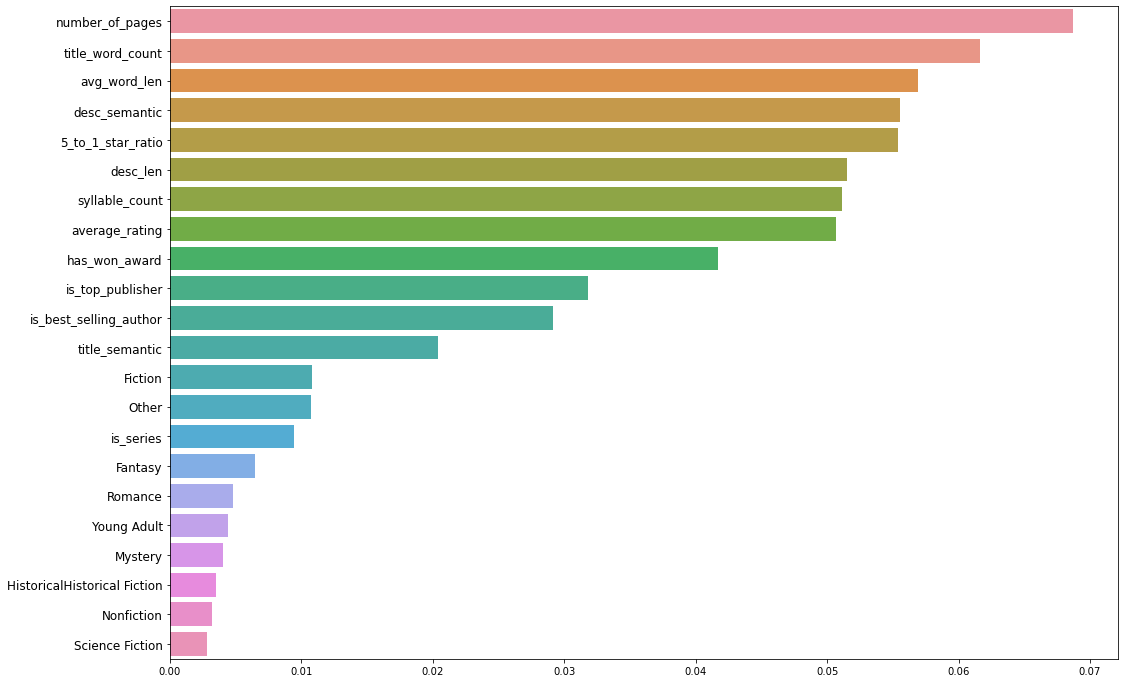

In [2672]:
ord_f1_features = list(reversed(X_train.columns[np.argsort(rf.feature_importances_[:22])]))
ord_f1_importances = list(reversed(rf.feature_importances_[np.argsort(rf.feature_importances_[:22])]))
plt.figure(figsize=(17,12))
sns.barplot(ord_f1_importances, ord_f1_features, orient='h')
plt.yticks(size=12);

In [2674]:
ord_f2_features = list(reversed(df2.columns[np.argsort(rf.feature_importances_[21:])]))
ord_f2_importances = list(reversed(rf.feature_importances_[22:][np.argsort(rf.feature_importances_[22:])]))
plt.figure(figsize=(17,12))
sns.barplot(ord_f2_importances, ord_f2_features, orient='h')
plt.yticks(size=12);

IndexError: index 28 is out of bounds for axis 0 with size 25

In [2675]:
confusion = confusion_matrix(y_test, predict_mine)

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

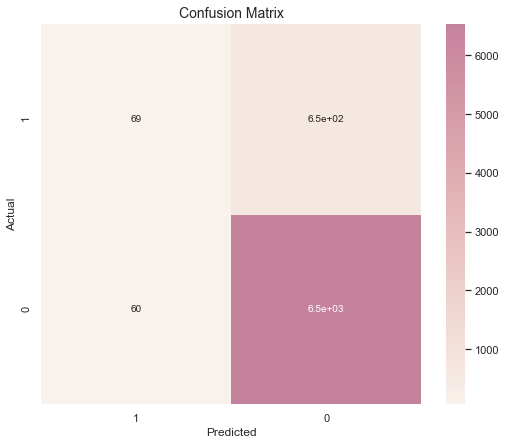

In [3032]:
sns.choose_cubehelix_palette(as_cmap=True)
plt.figure(figsize=(9,7))
cmap = sns.cubehelix_palette(start=0.0, rot=0.40, light=0.95, dark=0.6, gamma=1.0, as_cmap=True)
sns.heatmap(confusion, cmap=cmap, annot=True, square=True)
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12)
plt.title('Confusion Matrix', size=14)
ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()
plt.savefig('confusion.svg', transparent = True);

In [2763]:
X = books2.drop(columns=['title', 'author', 'average_rating', '5_to_1_star_ratio', 'has_won_award', 
                         'review_count', 'rating_count', 'publisher', 'des_no_stops',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings','nyt_best_seller'], axis=1)

y = books2['nyt_best_seller']
text = books2.des_no_stops

indices = X.index.tolist()
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size = 0.2, random_state=42)
text_train, text_val = books2.des_no_stops[train_indices], books2.des_no_stops[test_indices]

#Undersample majority class
X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)

#Logistic Regression on tf-idf features to pick out n number of best predictors
X_text_tr_rs = text_train.iloc[sample_indices]
y_text_tr_rs = y_tr_rs

df1, df2, vectorizer, scaler, idx = lr_select_best_words(X_text_tr_rs, text_val)

new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
new_X_test = np.concatenate((X_test, df2), axis=1)

lr = RandomForestClassifier(n_estimators=500)
lr.fit(new_X_train, y_tr_rs)
y_preds_probs = lr.predict_proba(new_X_test)[:,1]

predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

from collections import defaultdict
scores = defaultdict()
scores['Accuracy'] = accuracy_score(y_test, predict_mine)
scores['Precision'] = precision_score(y_test, predict_mine)
scores['Recall'] = recall_score(y_test, predict_mine)
scores['F1'] = f1_score(y_test, predict_mine)
scores['F_Beta'] = fbeta_score(y_test, predict_mine, beta=0)

In [2764]:
scores

defaultdict(None,
            {'Accuracy': 0.9015027322404372,
             'Precision': 0.5038167938931297,
             'Recall': 0.09141274238227147,
             'F1': 0.1547479484173505,
             'F_Beta': 0.5038167938931297})

In [2765]:
X_train.columns

Index(['number_of_pages', 'is_series', 'Fantasy', 'Fiction',
       'HistoricalHistorical Fiction', 'Mystery', 'Nonfiction', 'Other',
       'Romance', 'Science Fiction', 'Young Adult', 'is_top_publisher',
       'is_best_selling_author', 'title_semantic', 'desc_semantic',
       'title_word_count', 'desc_len', 'num_unique_words', 'avg_word_len',
       'syllable_count', 'lexicon_count', 'sentence_count',
       'flesch_reading_ease'],
      dtype='object')

In [3036]:
import importlib
importlib.reload(mpl); importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/matplotlib/pyplot.py'>

Text(0.5, 0, 'Feature Importances')

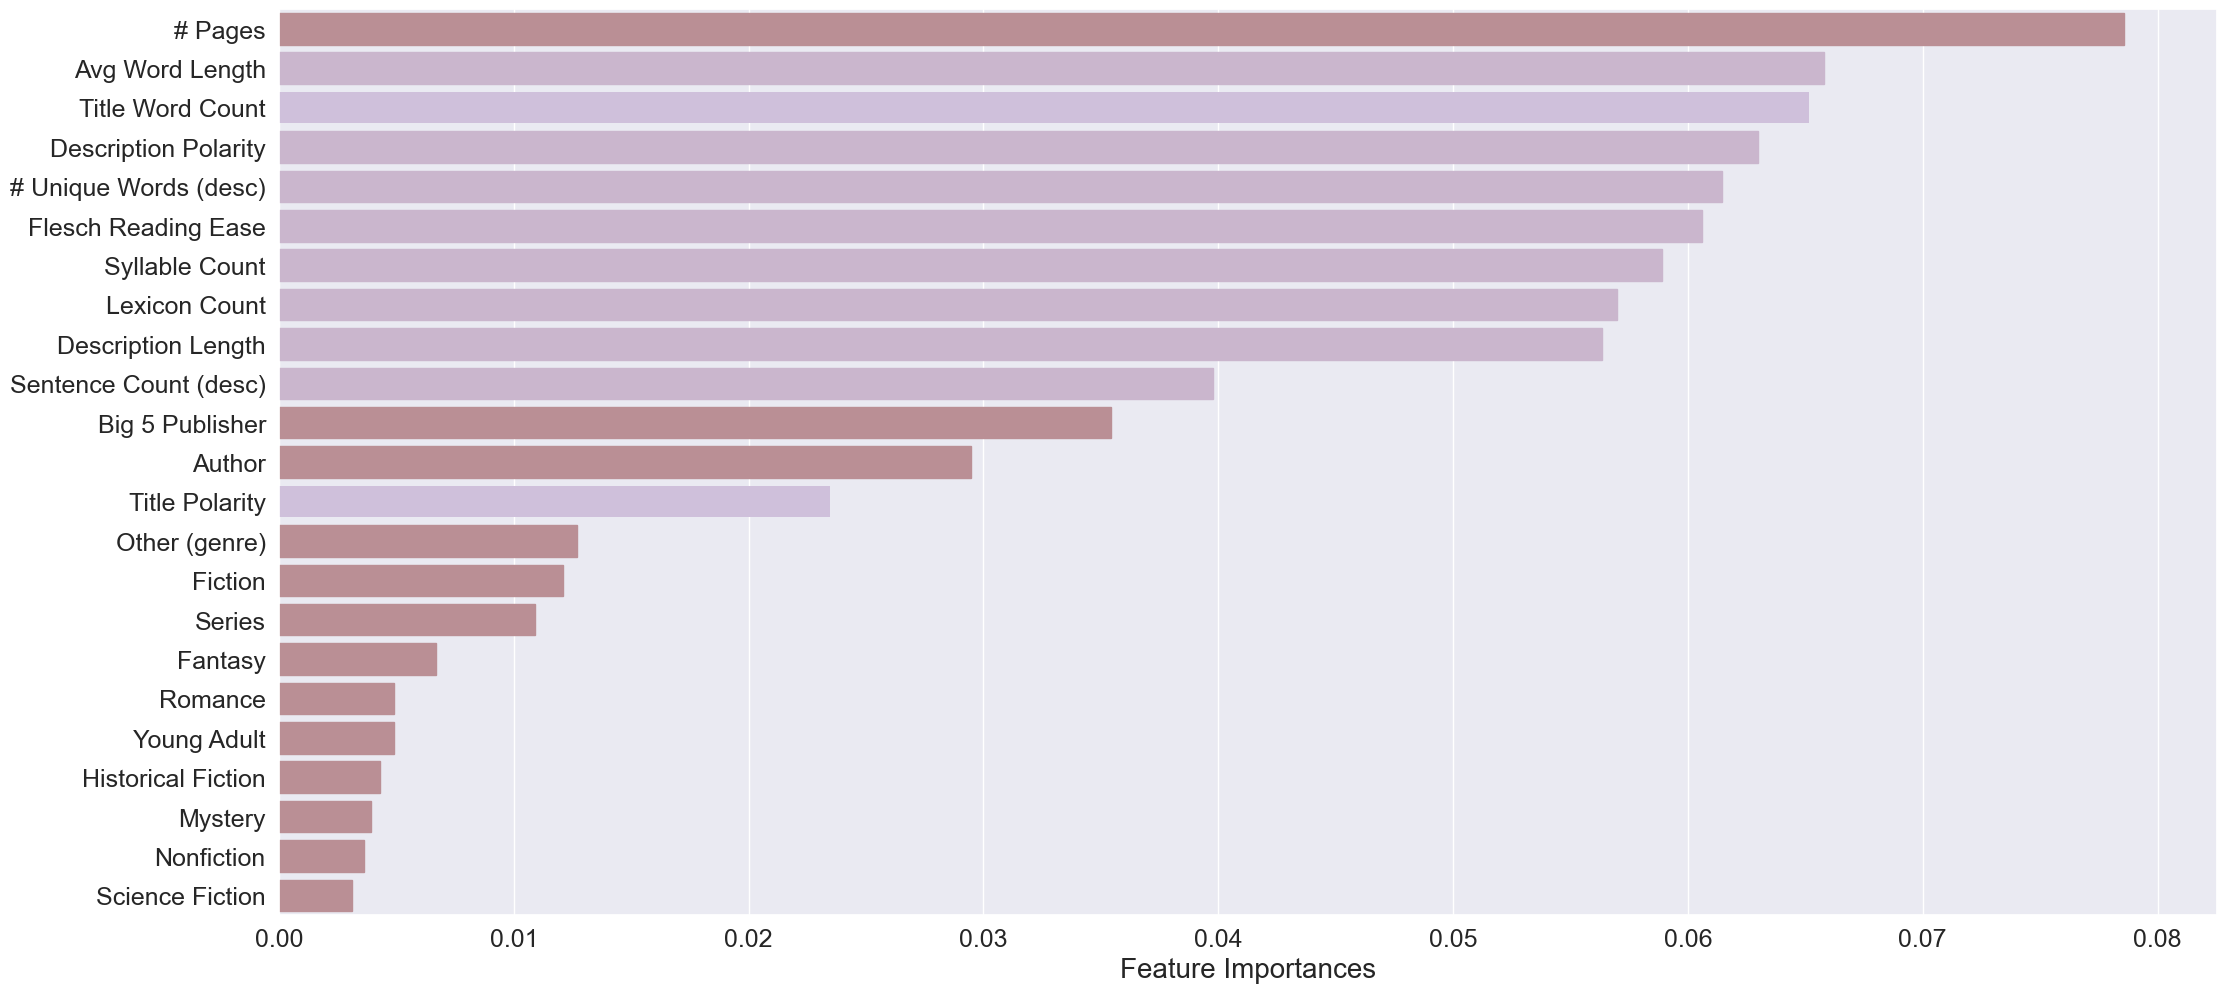

In [3059]:
ord_f1_features = list(reversed(X_train.columns[np.argsort(lr.feature_importances_[:23])]))
ord_f1_importances = list(reversed(lr.feature_importances_[np.argsort(lr.feature_importances_[:23])]))
plt.figure(figsize=(25,12))

ylabels = ['# Pages', 'Avg Word Length', 'Title Word Count', 'Description Polarity', '# Unique Words (desc)',
           'Flesch Reading Ease', 'Syllable Count', 'Lexicon Count', 'Description Length', 'Sentence Count (desc)', 
           'Big 5 Publisher', 'Author', 'Title Polarity', 'Other (genre)', 'Fiction', 'Series', 'Fantasy', 'Romance', 
           'Young Adult', 'Historical Fiction', 'Mystery', 'Nonfiction', 'Science Fiction']
desc = [1,3,4,5,6,7,8,9]
title = [2, 12]
book = [0, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

ax = sns.barplot(ord_f1_importances, ord_f1_features, orient='h', color='#CFBCDF')
ax.set_yticklabels(ylabels, fontsize=18)
for i in desc:
    ax.patches[i].set_color('#CFBCDF')
for i in book:
    ax.patches[i].set_color('#BA8F95')
#C3C9E9    
plt.yticks(size=18)
plt.xticks(size=18)
plt.xlabel('Feature Importances', size = 20)
#plt.title('Book Features and Importances', size = 25)
#plt.savefig('book_feat-importances_1.svg', format='svg', transparent=True)


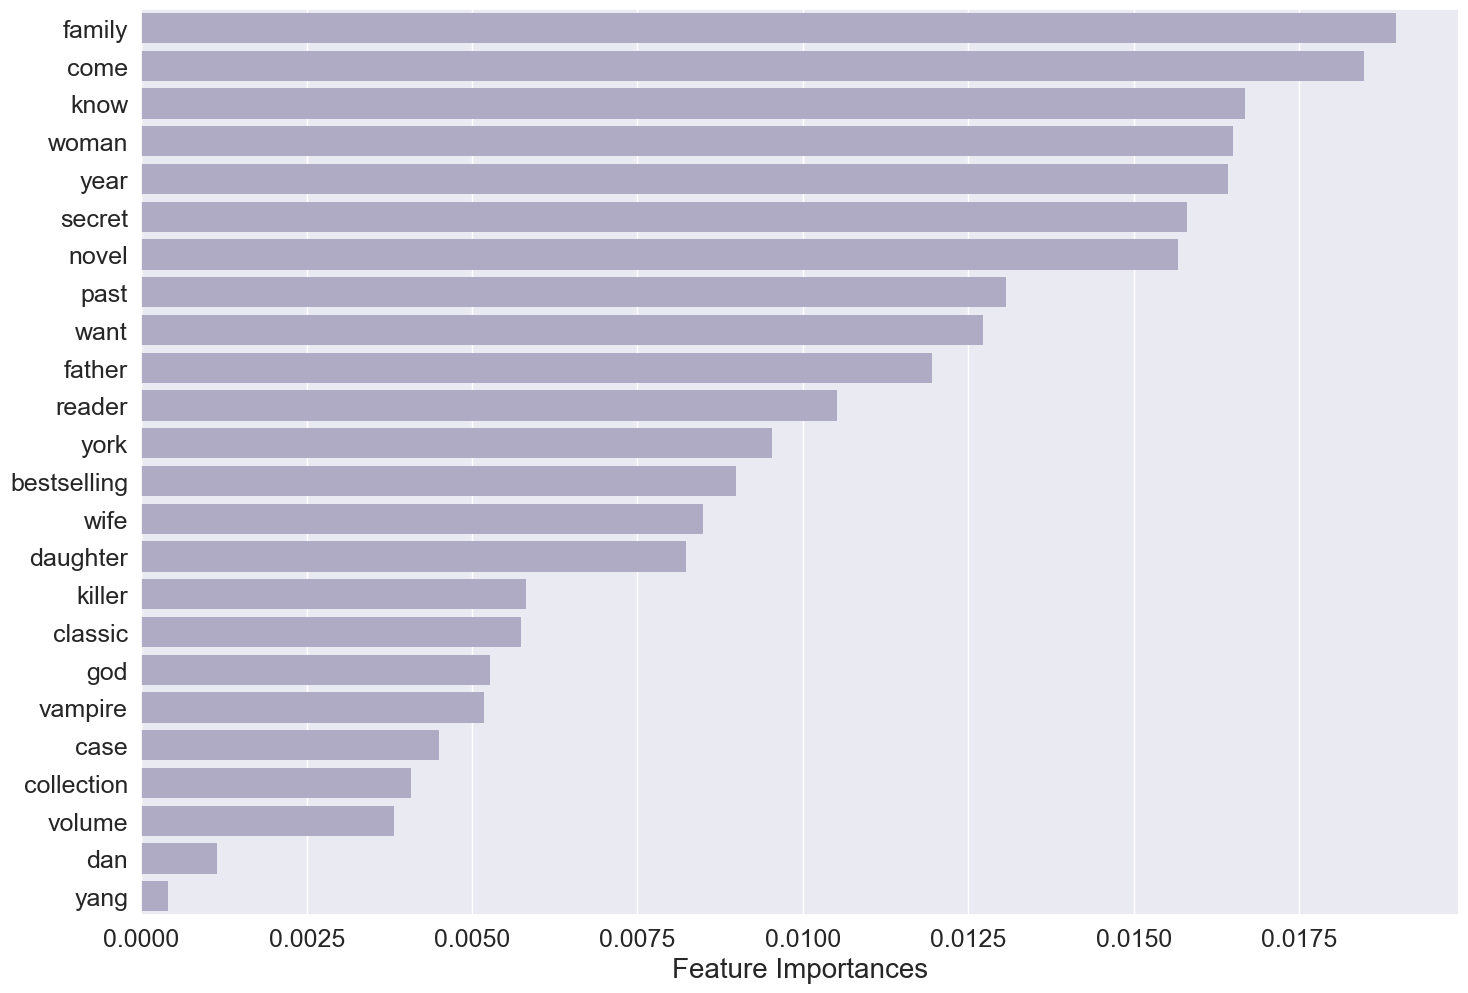

In [3060]:
ord_f2_features = list(reversed(df2.columns[np.argsort(lr.feature_importances_[23:])]))
ord_f2_importances = list(reversed(lr.feature_importances_[23:][np.argsort(lr.feature_importances_[23:])]))
plt.figure(figsize=(17,12))
ax = sns.barplot(ord_f2_importances, ord_f2_features, orient='h', color = '#ada7c9')
ax.set_yticklabels(labels = ord_f2_features, fontsize=18)

plt.yticks(size=18)
plt.xticks(size=18)
plt.xlabel('Feature Importances', size = 20)
#plt.title('Word Importances', size =15)
plt.savefig('word-importances.svg', format='svg', transparent=True)

/Users/emilyng/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression Model best F1 score 0.333 at prob decision threshold >= 0.624


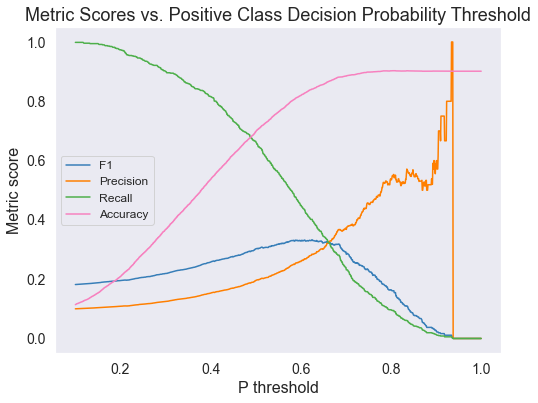

In [3021]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
#X_val, y_val = X_te, y_te # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = lr.predict_proba(new_X_test)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))    
    prec_scores.append(precision_score(y_test, model_val_labels))
    rec_scores.append(recall_score(y_test, model_val_labels))
    acc_scores.append(accuracy_score(y_test, model_val_labels))

fig = plt.figure(figsize=(8,6))
plt.plot(thresh_ps, f1_scores, color = CB_color_cycle[0])
plt.plot(thresh_ps, prec_scores, color = CB_color_cycle[1])
plt.plot(thresh_ps, rec_scores, color = CB_color_cycle[2])
plt.plot(thresh_ps, acc_scores, color = CB_color_cycle[3])

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold', size = 18)
plt.legend(['F1','Precision','Recall','Accuracy'], prop={'size': 12})
plt.xlabel('P threshold', size =16)
plt.ylabel('Metric score', size=16)
plt.yticks(size=14)
plt.xticks(size=14)
ax = plt.gca()
ax.grid(False)
plt.savefig('metrics_threshold.svg', facecolor=fig.get_facecolor(), edgecolor='none')


best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [2740]:
pd.to_pickle(vectorizer, 'vectorizer1.pkl')
pd.to_pickle(scaler, 'scaler1.pkl')

In [2768]:
word_imp = pd.DataFrame({'Word': ord_f2_features, 'Feature Importances': ord_f2_importances})
word_imp.to_csv('words.csv')

In [2769]:
confusion = confusion_matrix(y_test, predict_mine)

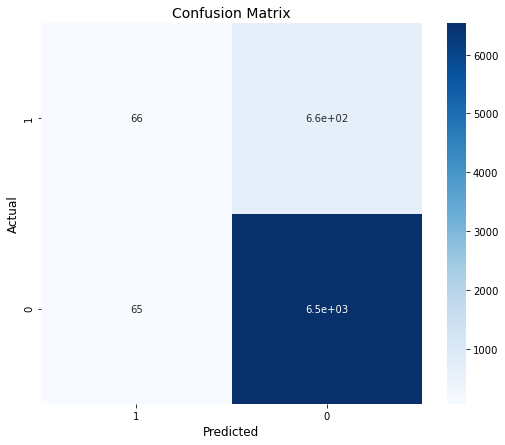

In [2770]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True)
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12)
plt.title('Confusion Matrix', size=14)
ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()
#plt.savefig('confusion.svg');

In [2771]:
X_train.columns

Index(['number_of_pages', 'is_series', 'Fantasy', 'Fiction',
       'HistoricalHistorical Fiction', 'Mystery', 'Nonfiction', 'Other',
       'Romance', 'Science Fiction', 'Young Adult', 'is_top_publisher',
       'is_best_selling_author', 'title_semantic', 'desc_semantic',
       'title_word_count', 'desc_len', 'num_unique_words', 'avg_word_len',
       'syllable_count', 'lexicon_count', 'sentence_count',
       'flesch_reading_ease'],
      dtype='object')

In [2773]:
X = books2.drop(columns=['title', 'author', 'average_rating', '5_to_1_star_ratio', 'has_won_award', 
                         'review_count', 'rating_count', 'publisher', 'des_no_stops',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings','nyt_best_seller'], axis=1)
y = books2['nyt_best_seller']
text = books2.des_no_stops

indices = X.index.tolist()
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size = 0.2, random_state=42)
text_train, text_val = books2.des_no_stops[train_indices], books2.des_no_stops[test_indices]

#Undersample majority class
X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)

#Logistic Regression on tf-idf features to pick out n number of best predictors
X_text_tr_rs = text_train.iloc[sample_indices]
y_text_tr_rs = y_tr_rs

df1, df2, vecotrizer, sacler, idx = lr_select_best_words(X_text_tr_rs, text_val)

new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
new_X_test = np.concatenate((X_test, df2), axis=1)

lr = RandomForestClassifier(n_estimators=750)
lr.fit(new_X_train, y_tr_rs)
y_preds_probs = lr.predict_proba(new_X_test)[:,1]

predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

from collections import defaultdict
scores = defaultdict()
scores['Accuracy'] = accuracy_score(y_test, predict_mine)
scores['Precision'] = precision_score(y_test, predict_mine)
scores['Recall'] = recall_score(y_test, predict_mine)
scores['F1'] = f1_score(y_test, predict_mine)
scores['F_Beta'] = fbeta_score(y_test, predict_mine, beta=0)

In [2774]:
scores

defaultdict(None,
            {'Accuracy': 0.9025956284153005,
             'Precision': 0.5348837209302325,
             'Recall': 0.09556786703601108,
             'F1': 0.16216216216216217,
             'F_Beta': 0.5348837209302325})

In [2775]:
pd.to_pickle(lr, 'lr_rf_model.pkl')

In [2776]:
pd.to_pickle(vecotrizer, 'vectorizer.pkl')
pd.to_pickle(sacler, 'scaler.pkl')

In [2777]:
pd.to_pickle(idx, 'idx.pkl')

In [2778]:
confusion = confusion_matrix(y_test, predict_mine)

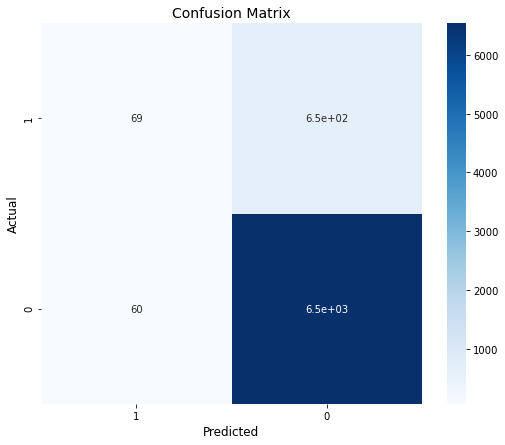

In [2779]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True)
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12)
plt.title('Confusion Matrix', size=14)
ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()
plt.savefig('confusion.svg');

In [2659]:
X = books2.drop(columns=['title', 'author', 'average_rating', '5_to_1_star_ratio', 'has_won_award', 
                         'review_count', 'rating_count', 'publisher', 'des_no_stops',
                         'description', 'description_processed', 'five_star_ratings', 
                         'four_star_ratings', 'three_star_ratings', 'two_star_ratings', 
                         'one_star_ratings','nyt_best_seller'], axis=1)

y = books2['nyt_best_seller']
text = books2.des_no_stops

indices = X.index.tolist()
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, indices, test_size = 0.2, random_state=42)
text_train, text_val = books2.des_no_stops[train_indices], books2.des_no_stops[test_indices]

#Undersample majority class
X_tr_rs, y_tr_rs, sample_indices = imb_undersample(X_train, y_train)

#Logistic Regression on tf-idf features to pick out n number of best predictors
X_text_tr_rs = text_train.iloc[sample_indices]
y_text_tr_rs = y_tr_rs

df1, df2 = lr_select_best_words(X_text_tr_rs, text_val)

new_X_train = np.concatenate((X_tr_rs, df1), axis=1)
new_X_test = np.concatenate((X_test, df2), axis=1)

lr = RandomForestClassifier(n_estimators=500)
lr.fit(new_X_train, y_tr_rs)
y_preds_probs = lr.predict_proba(new_X_test)[:,1]

predict_mine = np.where(y_preds_probs > 0.8, 1, 0)

from collections import defaultdict
scores = defaultdict()
scores['Accuracy'] = accuracy_score(y_test, predict_mine)
scores['Precision'] = precision_score(y_test, predict_mine)
scores['Recall'] = recall_score(y_test, predict_mine)
scores['F1'] = f1_score(y_test, predict_mine)
scores['F_Beta'] = fbeta_score(y_test, predict_mine, beta=0)

In [2660]:
scores

defaultdict(None,
            {'Accuracy': 0.9024590163934426,
             'Precision': 0.5303030303030303,
             'Recall': 0.09695290858725762,
             'F1': 0.1639344262295082,
             'F_Beta': 0.5303030303030303})

In [2661]:
X_train.columns

Index(['number_of_pages', 'is_series', 'Fantasy', 'Fiction',
       'HistoricalHistorical Fiction', 'Mystery', 'Nonfiction', 'Other',
       'Romance', 'Science Fiction', 'Young Adult', 'is_top_publisher',
       'is_best_selling_author', 'title_semantic', 'desc_semantic',
       'title_word_count', 'desc_len', 'num_unique_words', 'avg_word_len',
       'syllable_count', 'lexicon_count', 'sentence_count',
       'flesch_reading_ease'],
      dtype='object')

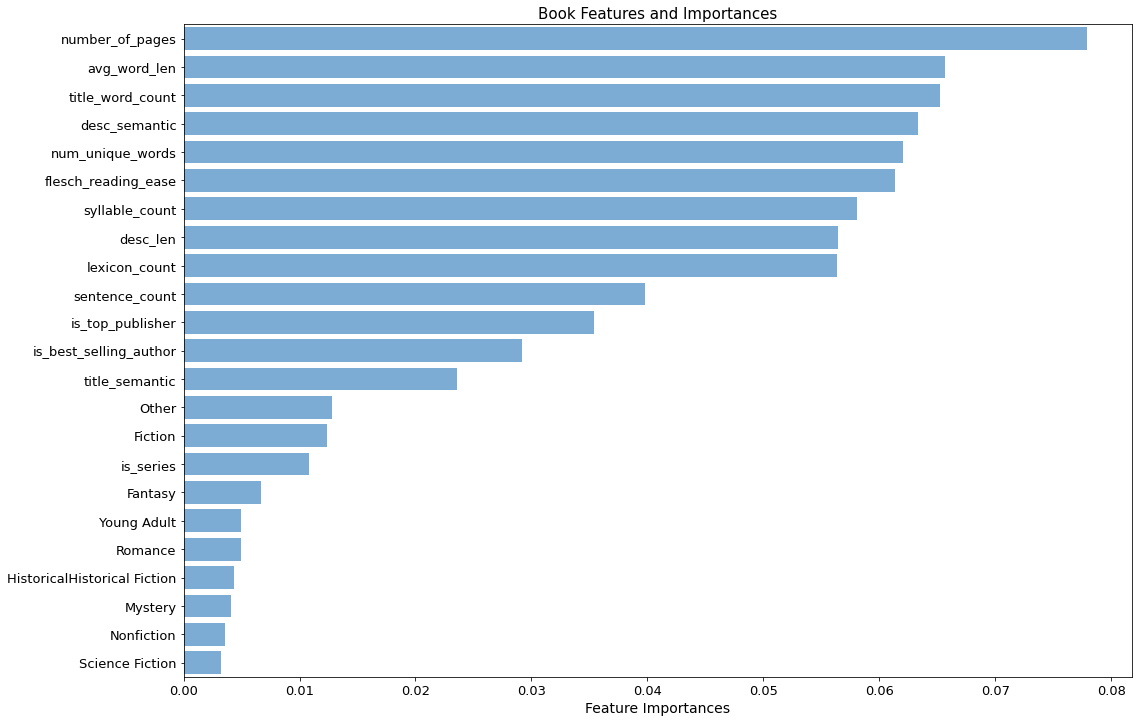

In [2662]:
ord_f1_features = list(reversed(X_train.columns[np.argsort(lr.feature_importances_[:23])]))
ord_f1_importances = list(reversed(lr.feature_importances_[np.argsort(lr.feature_importances_[:23])]))
plt.figure(figsize=(17,12))

ylabels = ['# Pages', 'Title Word Count', 'Avg Word Length', 'Description Semantic', '5-to-1 Star Ratio',
           'Flesch Reading Ease', '# Unique Words (desc)', 'Average Rating', 'Lexicon Count', 'Syllable Count',
           'Description Length', 'Award Winning', 'Sentence Count (desc)', 'Big 5 Publisher', 'Author',
           'Title Semantic', 'Fiction', 'Other', 'Series', 'Fantasy', 'Romance', 'Young Adult', 'Mystery',
           'Historical Fiction', 'Nonfiction', 'Science Fiction']

sns.barplot(ord_f1_importances, ord_f1_features, orient='h', color='#6DAEE2')
plt.yticks(size=13)
plt.xticks(size=13)
plt.xlabel('Feature Importances', size = 14)
plt.title('Book Features and Importances', size =15);

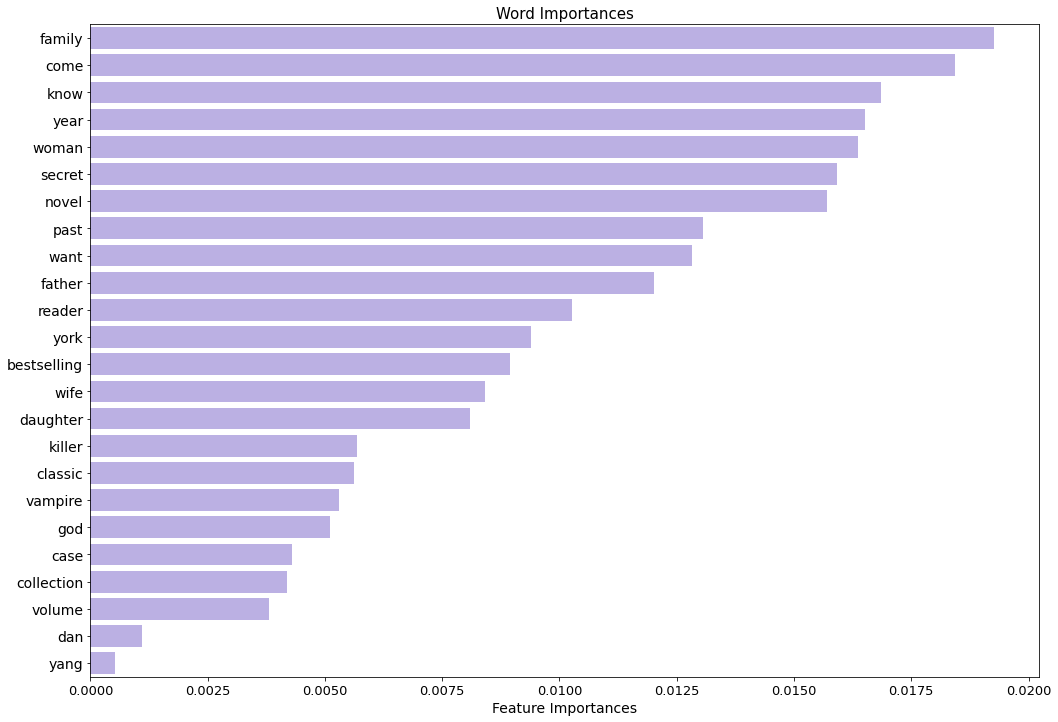

In [2663]:
ord_f2_features = list(reversed(df2.columns[np.argsort(lr.feature_importances_[23:])]))
ord_f2_importances = list(reversed(lr.feature_importances_[23:][np.argsort(lr.feature_importances_[23:])]))
plt.figure(figsize=(17,12))
sns.barplot(ord_f2_importances, ord_f2_features, orient='h', color = '#B6A8EB')
plt.yticks(size=14)
plt.xticks(size=13)
plt.xlabel('Feature Importances', size = 14)
plt.title('Word Importances', size =15);

In [2572]:
pd.to_pickle(lr, 'lr_rf_model.pkl')

In [2616]:
word_imp = pd.DataFrame({'Word': ord_f2_features, 'Feature Importances': ord_f2_importances})
word_imp.to_csv('words.csv')

In [2664]:
confusion = confusion_matrix(y_test, predict_mine)

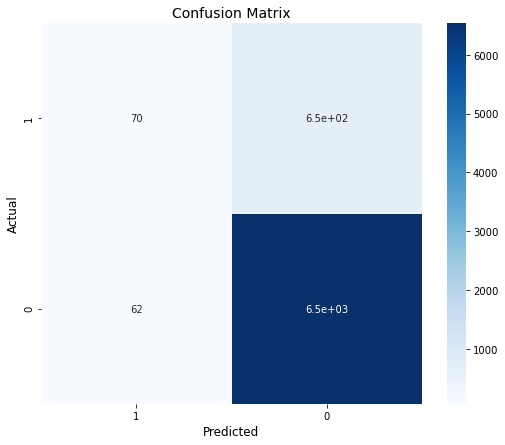

In [2665]:
plt.figure(figsize=(9,7))
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True)
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12)
plt.title('Confusion Matrix', size=14)
ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()
plt.savefig('confusion.svg');

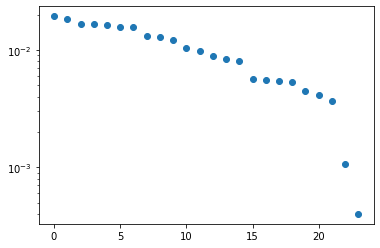

In [2815]:
word_imp
plt.scatter(range(len(word_imp)), word_imp['Feature Importances'])
plt.yscale('log')

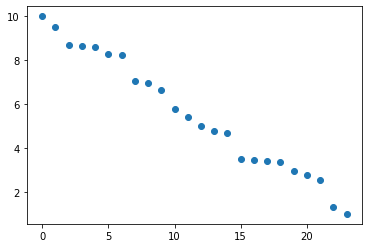

In [2812]:
a = np.array(word_imp['Feature Importances'])
new  = np.interp(a, (a.min(), a.max()), (1, +10))
plt.scatter(range(len(a)), new)